### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 35  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:13<101:46:49, 73.30s/it]

Entrenando:   0%|          | 2/5000 [02:26<101:58:18, 73.45s/it]

Entrenando:   0%|          | 3/5000 [03:47<106:43:09, 76.88s/it]

Entrenando:   0%|          | 4/5000 [05:20<115:30:58, 83.24s/it]

Entrenando:   0%|          | 5/5000 [06:56<121:52:48, 87.84s/it]

Entrenando:   0%|          | 6/5000 [09:02<139:36:43, 100.64s/it]

Entrenando:   0%|          | 7/5000 [10:54<144:37:53, 104.28s/it]

Entrenando:   0%|          | 8/5000 [12:52<150:58:03, 108.87s/it]

Entrenando:   0%|          | 9/5000 [14:39<149:59:26, 108.19s/it]

Entrenando:   0%|          | 10/5000 [16:31<151:26:03, 109.25s/it]

Entrenando:   0%|          | 11/5000 [18:28<154:55:33, 111.79s/it]

Entrenando:   0%|          | 12/5000 [21:16<178:35:21, 128.89s/it]

Entrenando:   0%|          | 13/5000 [24:27<204:40:11, 147.75s/it]

Entrenando:   0%|          | 14/5000 [27:17<213:38:00, 154.25s/it]

Entrenando:   0%|          | 15/5000 [30:29<229:28:23, 165.72s/it]

Entrenando:   0%|          | 16/5000 [33:23<233:03:25, 168.34s/it]

Entrenando:   0%|          | 17/5000 [36:26<238:57:26, 172.64s/it]

Entrenando:   0%|          | 18/5000 [39:36<246:13:19, 177.92s/it]

Entrenando:   0%|          | 19/5000 [43:27<268:22:08, 193.96s/it]

Entrenando:   0%|          | 20/5000 [47:27<287:23:02, 207.75s/it]

Entrenando:   0%|          | 21/5000 [51:17<296:16:20, 214.22s/it]

Entrenando:   0%|          | 22/5000 [55:05<302:13:03, 218.56s/it]

Entrenando:   0%|          | 23/5000 [58:56<307:17:19, 222.27s/it]

Entrenando:   0%|          | 24/5000 [1:02:47<310:48:41, 224.86s/it]

Entrenando:   0%|          | 25/5000 [1:06:37<312:37:06, 226.22s/it]

Entrenando:   1%|          | 26/5000 [1:10:29<315:09:28, 228.10s/it]

Entrenando:   1%|          | 27/5000 [1:14:27<319:11:56, 231.07s/it]

Entrenando:   1%|          | 28/5000 [1:18:33<325:30:26, 235.69s/it]

Entrenando:   1%|          | 29/5000 [1:22:39<329:33:09, 238.66s/it]

Entrenando:   1%|          | 30/5000 [1:26:40<330:16:28, 239.23s/it]

Entrenando:   1%|          | 31/5000 [1:30:50<334:38:40, 242.45s/it]

Entrenando:   1%|          | 32/5000 [1:34:24<322:49:52, 233.94s/it]

Entrenando:   1%|          | 33/5000 [1:37:53<312:39:36, 226.61s/it]

Entrenando:   1%|          | 34/5000 [1:41:00<295:55:15, 214.52s/it]

Entrenando:   1%|          | 35/5000 [1:44:06<284:20:50, 206.17s/it]

Entrenando:   1%|          | 36/5000 [1:47:06<273:26:02, 198.30s/it]

Entrenando:   1%|          | 37/5000 [1:50:11<267:41:43, 194.18s/it]

Entrenando:   1%|          | 38/5000 [1:53:17<264:17:27, 191.75s/it]

Entrenando:   1%|          | 39/5000 [1:56:09<256:07:33, 185.86s/it]

Entrenando:   1%|          | 40/5000 [1:59:01<250:22:24, 181.72s/it]

Entrenando:   1%|          | 41/5000 [2:01:53<246:18:56, 178.81s/it]

Entrenando:   1%|          | 42/5000 [2:04:42<242:22:37, 175.99s/it]

Entrenando:   1%|          | 43/5000 [2:07:55<249:11:59, 180.98s/it]

Entrenando:   1%|          | 44/5000 [2:10:46<244:54:58, 177.91s/it]

Entrenando:   1%|          | 45/5000 [2:13:46<245:39:00, 178.47s/it]

Entrenando:   1%|          | 46/5000 [2:16:48<247:17:11, 179.70s/it]

Entrenando:   1%|          | 47/5000 [2:19:24<237:18:39, 172.49s/it]

Entrenando:   1%|          | 48/5000 [2:22:00<230:32:07, 167.59s/it]

Entrenando:   1%|          | 49/5000 [2:24:34<224:50:02, 163.48s/it]

Entrenando:   1%|          | 50/5000 [2:27:07<220:26:34, 160.32s/it]

Iter  50: train_loss=6.8301, val_loss=7.0994, train_suc=0.668, train_err=0.176, train_inc=0.156 | val_suc=0.650, val_err=0.183, val_inc=0.166


Entrenando:   1%|          | 51/5000 [2:29:42<218:23:12, 158.86s/it]

Entrenando:   1%|          | 52/5000 [2:32:03<211:04:04, 153.57s/it]

Entrenando:   1%|          | 53/5000 [2:34:23<205:24:44, 149.48s/it]

Entrenando:   1%|          | 54/5000 [2:36:38<199:05:49, 144.92s/it]

Entrenando:   1%|          | 55/5000 [2:38:44<191:34:35, 139.47s/it]

Entrenando:   1%|          | 56/5000 [2:40:52<186:50:29, 136.05s/it]

Entrenando:   1%|          | 57/5000 [2:43:01<183:47:39, 133.86s/it]

Entrenando:   1%|          | 58/5000 [2:45:08<180:38:36, 131.59s/it]

Entrenando:   1%|          | 59/5000 [2:47:11<177:12:27, 129.11s/it]

Entrenando:   1%|          | 60/5000 [2:49:13<174:25:03, 127.11s/it]

Entrenando:   1%|          | 61/5000 [2:51:18<173:34:39, 126.52s/it]

Entrenando:   1%|          | 62/5000 [2:53:20<171:21:04, 124.92s/it]

Entrenando:   1%|▏         | 63/5000 [2:55:09<164:50:52, 120.21s/it]

Entrenando:   1%|▏         | 64/5000 [2:57:10<165:03:10, 120.38s/it]

Entrenando:   1%|▏         | 65/5000 [2:59:06<163:30:22, 119.28s/it]

Entrenando:   1%|▏         | 66/5000 [3:01:05<163:13:24, 119.09s/it]

Entrenando:   1%|▏         | 67/5000 [3:02:56<159:44:19, 116.57s/it]

Entrenando:   1%|▏         | 68/5000 [3:04:58<162:03:07, 118.29s/it]

Entrenando:   1%|▏         | 69/5000 [3:07:01<163:59:52, 119.73s/it]

Entrenando:   1%|▏         | 70/5000 [3:08:59<163:10:20, 119.15s/it]

Entrenando:   1%|▏         | 71/5000 [3:10:53<161:14:54, 117.77s/it]

Entrenando:   1%|▏         | 72/5000 [3:12:44<158:17:12, 115.63s/it]

Entrenando:   1%|▏         | 73/5000 [3:14:27<153:11:46, 111.94s/it]

Entrenando:   1%|▏         | 74/5000 [3:16:28<156:52:37, 114.65s/it]

Entrenando:   2%|▏         | 75/5000 [3:18:29<159:30:17, 116.59s/it]

Entrenando:   2%|▏         | 76/5000 [3:20:24<158:31:37, 115.90s/it]

Entrenando:   2%|▏         | 77/5000 [3:22:25<160:50:02, 117.61s/it]

Entrenando:   2%|▏         | 78/5000 [3:24:19<159:06:48, 116.38s/it]

Entrenando:   2%|▏         | 79/5000 [3:26:21<161:23:17, 118.06s/it]

Entrenando:   2%|▏         | 80/5000 [3:28:15<159:55:48, 117.02s/it]

Entrenando:   2%|▏         | 81/5000 [3:30:07<157:50:26, 115.52s/it]

Entrenando:   2%|▏         | 82/5000 [3:32:07<159:19:57, 116.63s/it]

Entrenando:   2%|▏         | 83/5000 [3:34:06<160:23:07, 117.43s/it]

Entrenando:   2%|▏         | 84/5000 [3:36:10<163:06:49, 119.45s/it]

Entrenando:   2%|▏         | 85/5000 [3:38:05<161:06:21, 118.00s/it]

Entrenando:   2%|▏         | 86/5000 [3:40:09<163:44:07, 119.95s/it]

Entrenando:   2%|▏         | 87/5000 [3:41:59<159:23:08, 116.79s/it]

Entrenando:   2%|▏         | 88/5000 [3:44:01<161:49:38, 118.60s/it]

Entrenando:   2%|▏         | 89/5000 [3:45:55<159:50:12, 117.17s/it]

Entrenando:   2%|▏         | 90/5000 [3:47:52<159:42:44, 117.10s/it]

Entrenando:   2%|▏         | 91/5000 [3:49:49<159:43:40, 117.14s/it]

Entrenando:   2%|▏         | 92/5000 [3:51:43<158:15:26, 116.08s/it]

Entrenando:   2%|▏         | 93/5000 [3:53:43<159:53:15, 117.30s/it]

Entrenando:   2%|▏         | 94/5000 [3:55:44<161:06:22, 118.22s/it]

Entrenando:   2%|▏         | 95/5000 [3:57:34<158:01:59, 115.99s/it]

Entrenando:   2%|▏         | 96/5000 [3:59:29<157:27:55, 115.59s/it]

Entrenando:   2%|▏         | 97/5000 [4:01:27<158:12:07, 116.16s/it]

Entrenando:   2%|▏         | 98/5000 [4:03:25<159:17:01, 116.98s/it]

Entrenando:   2%|▏         | 99/5000 [4:05:24<159:53:28, 117.45s/it]

Entrenando:   2%|▏         | 100/5000 [4:07:23<160:36:13, 117.99s/it]

Iter 100: train_loss=2.8525, val_loss=3.1764, train_suc=0.666, train_err=0.062, train_inc=0.273 | val_suc=0.645, val_err=0.064, val_inc=0.291
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:09:19<159:39:00, 117.32s/it]

Entrenando:   2%|▏         | 102/5000 [4:11:20<161:03:49, 118.38s/it]

Entrenando:   2%|▏         | 103/5000 [4:13:19<161:13:45, 118.53s/it]

Entrenando:   2%|▏         | 104/5000 [4:15:16<160:46:19, 118.21s/it]

Entrenando:   2%|▏         | 105/5000 [4:17:06<157:06:40, 115.55s/it]

Entrenando:   2%|▏         | 106/5000 [4:19:06<159:04:36, 117.02s/it]

Entrenando:   2%|▏         | 107/5000 [4:21:11<162:08:37, 119.30s/it]

Entrenando:   2%|▏         | 108/5000 [4:23:00<158:12:08, 116.42s/it]

Entrenando:   2%|▏         | 109/5000 [4:24:49<155:01:00, 114.10s/it]

Entrenando:   2%|▏         | 110/5000 [4:26:36<152:17:24, 112.12s/it]

Entrenando:   2%|▏         | 111/5000 [4:28:36<155:13:35, 114.30s/it]

Entrenando:   2%|▏         | 112/5000 [4:30:34<156:34:54, 115.32s/it]

Entrenando:   2%|▏         | 113/5000 [4:32:27<155:41:18, 114.69s/it]

Entrenando:   2%|▏         | 114/5000 [4:34:17<153:58:29, 113.45s/it]

Entrenando:   2%|▏         | 115/5000 [4:36:07<152:26:40, 112.34s/it]

Entrenando:   2%|▏         | 116/5000 [4:38:01<152:54:25, 112.71s/it]

Entrenando:   2%|▏         | 117/5000 [4:39:55<153:36:52, 113.25s/it]

Entrenando:   2%|▏         | 118/5000 [4:41:47<153:04:21, 112.88s/it]

Entrenando:   2%|▏         | 119/5000 [4:43:43<154:13:41, 113.75s/it]

Entrenando:   2%|▏         | 120/5000 [4:45:39<154:56:19, 114.30s/it]

Entrenando:   2%|▏         | 121/5000 [4:47:38<157:00:29, 115.85s/it]

Entrenando:   2%|▏         | 122/5000 [4:49:33<156:43:05, 115.66s/it]

Entrenando:   2%|▏         | 123/5000 [4:51:25<155:07:44, 114.51s/it]

Entrenando:   2%|▏         | 124/5000 [4:53:19<155:00:07, 114.44s/it]

Entrenando:   2%|▎         | 125/5000 [4:55:18<156:36:55, 115.65s/it]

Entrenando:   3%|▎         | 126/5000 [4:57:18<158:14:50, 116.88s/it]

Entrenando:   3%|▎         | 127/5000 [4:59:45<170:27:44, 125.93s/it]

Entrenando:   3%|▎         | 128/5000 [5:03:29<210:36:01, 155.62s/it]

Entrenando:   3%|▎         | 129/5000 [5:07:05<234:47:41, 173.53s/it]

Entrenando:   3%|▎         | 130/5000 [5:10:38<251:00:51, 185.55s/it]

Entrenando:   3%|▎         | 131/5000 [5:14:18<264:35:40, 195.63s/it]

Entrenando:   3%|▎         | 132/5000 [5:17:53<272:45:12, 201.71s/it]

Entrenando:   3%|▎         | 133/5000 [5:21:34<280:15:28, 207.30s/it]

Entrenando:   3%|▎         | 134/5000 [5:25:00<279:51:22, 207.05s/it]

Entrenando:   3%|▎         | 135/5000 [5:28:24<278:21:58, 205.99s/it]

Entrenando:   3%|▎         | 136/5000 [5:31:49<278:06:21, 205.84s/it]

Entrenando:   3%|▎         | 137/5000 [5:35:30<284:12:48, 210.40s/it]

Entrenando:   3%|▎         | 138/5000 [5:39:06<286:11:00, 211.90s/it]

Entrenando:   3%|▎         | 139/5000 [5:42:50<291:08:33, 215.62s/it]

Entrenando:   3%|▎         | 140/5000 [5:46:31<293:14:19, 217.21s/it]

Entrenando:   3%|▎         | 141/5000 [5:50:07<292:40:20, 216.84s/it]

Entrenando:   3%|▎         | 142/5000 [5:53:42<291:56:16, 216.34s/it]

Entrenando:   3%|▎         | 143/5000 [5:57:19<291:57:24, 216.40s/it]

Entrenando:   3%|▎         | 144/5000 [6:00:57<292:45:55, 217.04s/it]

Entrenando:   3%|▎         | 145/5000 [6:04:40<294:56:02, 218.69s/it]

Entrenando:   3%|▎         | 146/5000 [6:08:12<292:20:03, 216.81s/it]

Entrenando:   3%|▎         | 147/5000 [6:11:41<289:01:13, 214.40s/it]

Entrenando:   3%|▎         | 148/5000 [6:14:46<276:56:12, 205.48s/it]

Entrenando:   3%|▎         | 149/5000 [6:17:45<266:13:43, 197.57s/it]

Entrenando:   3%|▎         | 150/5000 [6:20:44<258:47:14, 192.09s/it]

Iter 150: train_loss=1.0520, val_loss=1.0804, train_suc=0.683, train_err=0.002, train_inc=0.315 | val_suc=0.663, val_err=0.002, val_inc=0.335


Entrenando:   3%|▎         | 151/5000 [6:23:33<249:17:32, 185.08s/it]

Entrenando:   3%|▎         | 152/5000 [6:26:22<242:52:45, 180.36s/it]

Entrenando:   3%|▎         | 153/5000 [6:29:04<235:19:31, 174.78s/it]

Entrenando:   3%|▎         | 154/5000 [6:31:57<234:32:56, 174.24s/it]

Entrenando:   3%|▎         | 155/5000 [6:34:44<231:44:39, 172.19s/it]

Entrenando:   3%|▎         | 156/5000 [6:37:26<227:25:35, 169.02s/it]

Entrenando:   3%|▎         | 157/5000 [6:40:01<221:38:46, 164.76s/it]

Entrenando:   3%|▎         | 158/5000 [6:42:20<211:31:17, 157.27s/it]

Entrenando:   3%|▎         | 159/5000 [6:44:42<205:03:16, 152.49s/it]

Entrenando:   3%|▎         | 160/5000 [6:47:00<199:21:15, 148.28s/it]

Entrenando:   3%|▎         | 161/5000 [6:49:20<196:01:30, 145.83s/it]

Entrenando:   3%|▎         | 162/5000 [6:51:40<193:20:37, 143.87s/it]

Entrenando:   3%|▎         | 163/5000 [6:54:02<192:37:17, 143.36s/it]

Entrenando:   3%|▎         | 164/5000 [6:56:21<190:57:36, 142.15s/it]

Entrenando:   3%|▎         | 165/5000 [6:58:40<189:43:24, 141.26s/it]

Entrenando:   3%|▎         | 166/5000 [7:00:50<184:54:52, 137.71s/it]

Entrenando:   3%|▎         | 167/5000 [7:02:58<180:53:12, 134.74s/it]

Entrenando:   3%|▎         | 168/5000 [7:05:07<178:54:26, 133.29s/it]

Entrenando:   3%|▎         | 169/5000 [7:07:17<177:27:59, 132.25s/it]

Entrenando:   3%|▎         | 170/5000 [7:09:27<176:27:25, 131.52s/it]

Entrenando:   3%|▎         | 171/5000 [7:11:28<172:08:30, 128.33s/it]

Entrenando:   3%|▎         | 172/5000 [7:13:27<168:21:03, 125.53s/it]

Entrenando:   3%|▎         | 173/5000 [7:15:26<165:31:41, 123.45s/it]

Entrenando:   3%|▎         | 174/5000 [7:17:23<163:01:49, 121.61s/it]

Entrenando:   4%|▎         | 175/5000 [7:19:19<160:37:12, 119.84s/it]

Entrenando:   4%|▎         | 176/5000 [7:21:18<160:33:42, 119.82s/it]

Entrenando:   4%|▎         | 177/5000 [7:23:15<159:21:48, 118.95s/it]

Entrenando:   4%|▎         | 178/5000 [7:25:12<158:33:44, 118.38s/it]

Entrenando:   4%|▎         | 179/5000 [7:26:56<152:37:22, 113.97s/it]

Entrenando:   4%|▎         | 180/5000 [7:28:54<154:00:58, 115.03s/it]

Entrenando:   4%|▎         | 181/5000 [7:30:47<153:17:00, 114.51s/it]

Entrenando:   4%|▎         | 182/5000 [7:32:40<152:36:24, 114.03s/it]

Entrenando:   4%|▎         | 183/5000 [7:34:36<153:16:01, 114.54s/it]

Entrenando:   4%|▎         | 184/5000 [7:36:37<156:05:19, 116.68s/it]

Entrenando:   4%|▎         | 185/5000 [7:38:36<156:56:25, 117.34s/it]

Entrenando:   4%|▎         | 186/5000 [7:40:36<157:46:48, 117.99s/it]

Entrenando:   4%|▎         | 187/5000 [7:42:36<158:32:13, 118.58s/it]

Entrenando:   4%|▍         | 188/5000 [7:44:35<158:51:21, 118.84s/it]

Entrenando:   4%|▍         | 189/5000 [7:46:33<158:41:39, 118.75s/it]

Entrenando:   4%|▍         | 190/5000 [7:48:25<155:56:05, 116.71s/it]

Entrenando:   4%|▍         | 191/5000 [7:50:19<154:37:05, 115.75s/it]

Entrenando:   4%|▍         | 192/5000 [7:52:17<155:40:51, 116.57s/it]

Entrenando:   4%|▍         | 193/5000 [7:54:11<154:35:23, 115.77s/it]

Entrenando:   4%|▍         | 194/5000 [7:56:08<155:04:45, 116.16s/it]

Entrenando:   4%|▍         | 195/5000 [7:58:00<153:13:19, 114.80s/it]

Entrenando:   4%|▍         | 196/5000 [7:59:58<154:29:38, 115.77s/it]

Entrenando:   4%|▍         | 197/5000 [8:01:45<150:43:51, 112.98s/it]

Entrenando:   4%|▍         | 198/5000 [8:03:42<152:33:06, 114.37s/it]

Entrenando:   4%|▍         | 199/5000 [8:05:32<150:45:36, 113.05s/it]

Entrenando:   4%|▍         | 200/5000 [8:07:23<149:49:52, 112.37s/it]

Iter 200: train_loss=0.8771, val_loss=0.9224, train_suc=0.711, train_err=0.000, train_inc=0.289 | val_suc=0.693, val_err=0.000, val_inc=0.307
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:09:12<148:21:18, 111.29s/it]

Entrenando:   4%|▍         | 202/5000 [8:11:09<150:51:54, 113.20s/it]

Entrenando:   4%|▍         | 203/5000 [8:13:06<152:08:18, 114.18s/it]

Entrenando:   4%|▍         | 204/5000 [8:15:07<154:48:35, 116.20s/it]

Entrenando:   4%|▍         | 205/5000 [8:17:05<155:31:03, 116.76s/it]

Entrenando:   4%|▍         | 206/5000 [8:19:10<158:57:04, 119.36s/it]

Entrenando:   4%|▍         | 207/5000 [8:21:11<159:26:13, 119.75s/it]

Entrenando:   4%|▍         | 208/5000 [8:23:19<162:50:11, 122.33s/it]

Entrenando:   4%|▍         | 209/5000 [8:25:18<161:18:07, 121.20s/it]

Entrenando:   4%|▍         | 210/5000 [8:27:15<159:31:38, 119.90s/it]

Entrenando:   4%|▍         | 211/5000 [8:30:15<183:46:19, 138.15s/it]

Entrenando:   4%|▍         | 212/5000 [8:33:04<195:50:32, 147.25s/it]

Entrenando:   4%|▍         | 213/5000 [8:36:05<209:09:11, 157.29s/it]

Entrenando:   4%|▍         | 214/5000 [8:39:21<224:43:16, 169.03s/it]

Entrenando:   4%|▍         | 215/5000 [8:42:25<230:49:15, 173.66s/it]

Entrenando:   4%|▍         | 216/5000 [8:45:29<234:30:48, 176.47s/it]

Entrenando:   4%|▍         | 217/5000 [8:48:27<235:28:00, 177.23s/it]

Entrenando:   4%|▍         | 218/5000 [8:51:32<238:23:34, 179.47s/it]

Entrenando:   4%|▍         | 219/5000 [8:54:31<238:13:05, 179.37s/it]

Entrenando:   4%|▍         | 220/5000 [8:57:37<240:51:36, 181.40s/it]

Entrenando:   4%|▍         | 221/5000 [9:00:32<237:55:15, 179.22s/it]

Entrenando:   4%|▍         | 222/5000 [9:03:22<234:29:11, 176.67s/it]

Entrenando:   4%|▍         | 223/5000 [9:06:18<234:08:56, 176.46s/it]

Entrenando:   4%|▍         | 224/5000 [9:09:31<240:41:29, 181.43s/it]

Entrenando:   4%|▍         | 225/5000 [9:12:38<242:55:34, 183.15s/it]

Entrenando:   5%|▍         | 226/5000 [9:15:36<240:36:20, 181.44s/it]

Entrenando:   5%|▍         | 227/5000 [9:18:50<245:42:15, 185.32s/it]

Entrenando:   5%|▍         | 228/5000 [9:21:42<240:16:19, 181.26s/it]

Entrenando:   5%|▍         | 229/5000 [9:24:32<235:51:56, 177.97s/it]

Entrenando:   5%|▍         | 230/5000 [9:27:38<238:51:37, 180.27s/it]

Entrenando:   5%|▍         | 231/5000 [9:30:28<234:38:01, 177.12s/it]

Entrenando:   5%|▍         | 232/5000 [9:33:24<234:04:23, 176.73s/it]

Entrenando:   5%|▍         | 233/5000 [9:36:38<241:02:10, 182.03s/it]

Entrenando:   5%|▍         | 234/5000 [9:39:46<243:26:14, 183.88s/it]

Entrenando:   5%|▍         | 235/5000 [9:42:45<241:29:42, 182.45s/it]

Entrenando:   5%|▍         | 236/5000 [9:45:57<245:09:42, 185.26s/it]

Entrenando:   5%|▍         | 237/5000 [9:49:04<245:35:38, 185.63s/it]

Entrenando:   5%|▍         | 238/5000 [9:52:07<244:50:30, 185.10s/it]

Entrenando:   5%|▍         | 239/5000 [9:54:55<237:50:18, 179.84s/it]

Entrenando:   5%|▍         | 240/5000 [9:57:51<236:10:49, 178.62s/it]

Entrenando:   5%|▍         | 241/5000 [10:00:44<233:55:12, 176.95s/it]

Entrenando:   5%|▍         | 242/5000 [10:03:44<235:04:56, 177.87s/it]

Entrenando:   5%|▍         | 243/5000 [10:06:43<235:29:04, 178.21s/it]

Entrenando:   5%|▍         | 244/5000 [10:09:49<238:29:14, 180.52s/it]

Entrenando:   5%|▍         | 245/5000 [10:12:40<234:37:03, 177.63s/it]

Entrenando:   5%|▍         | 246/5000 [10:15:41<236:11:01, 178.85s/it]

Entrenando:   5%|▍         | 247/5000 [10:18:35<234:11:58, 177.39s/it]

Entrenando:   5%|▍         | 248/5000 [10:21:37<235:48:45, 178.65s/it]

Entrenando:   5%|▍         | 249/5000 [10:24:36<236:03:49, 178.87s/it]

Entrenando:   5%|▌         | 250/5000 [10:27:15<228:11:32, 172.95s/it]

Iter 250: train_loss=0.7688, val_loss=0.8426, train_suc=0.736, train_err=0.000, train_inc=0.264 | val_suc=0.720, val_err=0.000, val_inc=0.280


Entrenando:   5%|▌         | 251/5000 [10:29:56<223:04:30, 169.10s/it]

Entrenando:   5%|▌         | 252/5000 [10:32:49<224:53:47, 170.52s/it]

Entrenando:   5%|▌         | 253/5000 [10:35:44<226:22:55, 171.68s/it]

Entrenando:   5%|▌         | 254/5000 [10:38:42<228:54:25, 173.63s/it]

Entrenando:   5%|▌         | 255/5000 [10:41:42<231:26:13, 175.59s/it]

Entrenando:   5%|▌         | 256/5000 [10:44:42<233:15:00, 177.00s/it]

Entrenando:   5%|▌         | 257/5000 [10:47:49<237:04:36, 179.94s/it]

Entrenando:   5%|▌         | 258/5000 [10:50:43<234:38:12, 178.13s/it]

Entrenando:   5%|▌         | 259/5000 [10:53:33<231:14:49, 175.59s/it]

Entrenando:   5%|▌         | 260/5000 [10:56:27<230:41:12, 175.21s/it]

Entrenando:   5%|▌         | 261/5000 [10:59:37<236:24:58, 179.59s/it]

Entrenando:   5%|▌         | 262/5000 [11:02:31<234:18:31, 178.03s/it]

Entrenando:   5%|▌         | 263/5000 [11:05:17<229:29:42, 174.41s/it]

Entrenando:   5%|▌         | 264/5000 [11:08:24<234:19:59, 178.12s/it]

Entrenando:   5%|▌         | 265/5000 [11:11:16<231:37:24, 176.10s/it]

Entrenando:   5%|▌         | 266/5000 [11:14:17<233:42:59, 177.73s/it]

Entrenando:   5%|▌         | 267/5000 [11:17:26<237:59:00, 181.01s/it]

Entrenando:   5%|▌         | 268/5000 [11:20:31<239:43:18, 182.37s/it]

Entrenando:   5%|▌         | 269/5000 [11:23:35<240:05:32, 182.70s/it]

Entrenando:   5%|▌         | 270/5000 [11:26:28<236:27:37, 179.97s/it]

Entrenando:   5%|▌         | 271/5000 [11:29:32<237:45:53, 181.00s/it]

Entrenando:   5%|▌         | 272/5000 [11:32:27<235:35:46, 179.39s/it]

Entrenando:   5%|▌         | 273/5000 [11:35:31<237:12:54, 180.66s/it]

Entrenando:   5%|▌         | 274/5000 [11:38:30<236:29:42, 180.15s/it]

Entrenando:   6%|▌         | 275/5000 [11:41:27<235:19:38, 179.30s/it]

Entrenando:   6%|▌         | 276/5000 [11:44:30<236:45:15, 180.42s/it]

Entrenando:   6%|▌         | 277/5000 [11:47:26<234:49:28, 178.99s/it]

Entrenando:   6%|▌         | 278/5000 [11:50:26<235:15:17, 179.36s/it]

Entrenando:   6%|▌         | 279/5000 [11:53:16<231:35:41, 176.60s/it]

Entrenando:   6%|▌         | 280/5000 [11:56:13<231:42:28, 176.73s/it]

Entrenando:   6%|▌         | 281/5000 [11:59:06<230:07:01, 175.55s/it]

Entrenando:   6%|▌         | 282/5000 [12:02:04<231:02:18, 176.29s/it]

Entrenando:   6%|▌         | 283/5000 [12:04:54<228:32:34, 174.42s/it]

Entrenando:   6%|▌         | 284/5000 [12:07:51<229:15:57, 175.01s/it]

Entrenando:   6%|▌         | 285/5000 [12:10:47<229:54:22, 175.54s/it]

Entrenando:   6%|▌         | 286/5000 [12:13:38<228:01:58, 174.14s/it]

Entrenando:   6%|▌         | 287/5000 [12:16:33<228:05:55, 174.23s/it]

Entrenando:   6%|▌         | 288/5000 [12:19:27<227:54:20, 174.12s/it]

Entrenando:   6%|▌         | 289/5000 [12:22:20<227:27:10, 173.81s/it]

Entrenando:   6%|▌         | 290/5000 [12:25:29<233:20:11, 178.35s/it]

Entrenando:   6%|▌         | 291/5000 [12:28:22<231:15:21, 176.79s/it]

Entrenando:   6%|▌         | 292/5000 [12:31:20<231:50:59, 177.29s/it]

Entrenando:   6%|▌         | 293/5000 [12:34:14<230:28:50, 176.28s/it]

Entrenando:   6%|▌         | 294/5000 [12:37:22<234:56:01, 179.72s/it]

Entrenando:   6%|▌         | 295/5000 [12:40:13<231:30:45, 177.14s/it]

Entrenando:   6%|▌         | 296/5000 [12:43:05<229:37:37, 175.74s/it]

Entrenando:   6%|▌         | 297/5000 [12:46:05<231:06:56, 176.91s/it]

Entrenando:   6%|▌         | 298/5000 [12:48:55<228:26:48, 174.91s/it]

Entrenando:   6%|▌         | 299/5000 [12:51:58<231:15:25, 177.10s/it]

Entrenando:   6%|▌         | 300/5000 [12:54:50<229:30:54, 175.80s/it]

Iter 300: train_loss=0.7422, val_loss=0.7878, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.738, val_err=0.000, val_inc=0.262
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:57:50<230:50:08, 176.85s/it]

Entrenando:   6%|▌         | 302/5000 [13:00:47<231:04:53, 177.07s/it]

Entrenando:   6%|▌         | 303/5000 [13:03:36<227:46:39, 174.58s/it]

Entrenando:   6%|▌         | 304/5000 [13:06:21<224:10:56, 171.86s/it]

Entrenando:   6%|▌         | 305/5000 [13:09:16<225:15:52, 172.73s/it]

Entrenando:   6%|▌         | 306/5000 [13:12:15<227:28:21, 174.46s/it]

Entrenando:   6%|▌         | 307/5000 [13:15:05<225:53:58, 173.29s/it]

Entrenando:   6%|▌         | 308/5000 [13:18:11<230:36:03, 176.93s/it]

Entrenando:   6%|▌         | 309/5000 [13:21:13<232:50:01, 178.68s/it]

Entrenando:   6%|▌         | 310/5000 [13:24:20<236:00:21, 181.16s/it]

Entrenando:   6%|▌         | 311/5000 [13:27:13<232:33:55, 178.55s/it]

Entrenando:   6%|▌         | 312/5000 [13:30:14<233:27:50, 179.28s/it]

Entrenando:   6%|▋         | 313/5000 [13:33:19<235:30:59, 180.90s/it]

Entrenando:   6%|▋         | 314/5000 [13:36:29<239:11:04, 183.75s/it]

Entrenando:   6%|▋         | 315/5000 [13:39:33<239:08:58, 183.76s/it]

Entrenando:   6%|▋         | 316/5000 [13:42:56<246:50:49, 189.72s/it]

Entrenando:   6%|▋         | 317/5000 [13:45:47<239:23:14, 184.03s/it]

Entrenando:   6%|▋         | 318/5000 [13:48:40<234:55:51, 180.64s/it]

Entrenando:   6%|▋         | 319/5000 [13:51:46<236:53:36, 182.19s/it]

Entrenando:   6%|▋         | 320/5000 [13:54:46<236:07:26, 181.63s/it]

Entrenando:   6%|▋         | 321/5000 [13:57:56<239:25:09, 184.21s/it]

Entrenando:   6%|▋         | 322/5000 [14:00:49<235:01:33, 180.87s/it]

Entrenando:   6%|▋         | 323/5000 [14:03:57<237:44:55, 183.00s/it]

Entrenando:   6%|▋         | 324/5000 [14:07:00<237:44:43, 183.04s/it]

Entrenando:   6%|▋         | 325/5000 [14:10:21<244:34:52, 188.34s/it]

Entrenando:   7%|▋         | 326/5000 [14:13:24<242:32:38, 186.81s/it]

Entrenando:   7%|▋         | 327/5000 [14:16:52<250:37:31, 193.08s/it]

Entrenando:   7%|▋         | 328/5000 [14:19:58<247:58:14, 191.07s/it]

Entrenando:   7%|▋         | 329/5000 [14:23:08<247:22:51, 190.66s/it]

Entrenando:   7%|▋         | 330/5000 [14:26:09<243:23:47, 187.63s/it]

Entrenando:   7%|▋         | 331/5000 [14:28:55<235:13:21, 181.37s/it]

Entrenando:   7%|▋         | 332/5000 [14:31:50<232:20:05, 179.18s/it]

Entrenando:   7%|▋         | 333/5000 [14:34:46<231:12:55, 178.35s/it]

Entrenando:   7%|▋         | 334/5000 [14:38:04<238:48:24, 184.25s/it]

Entrenando:   7%|▋         | 335/5000 [14:41:11<239:40:28, 184.96s/it]

Entrenando:   7%|▋         | 336/5000 [14:44:10<237:20:24, 183.20s/it]

Entrenando:   7%|▋         | 337/5000 [14:47:08<235:24:53, 181.75s/it]

Entrenando:   7%|▋         | 338/5000 [14:50:06<233:46:19, 180.52s/it]

Entrenando:   7%|▋         | 339/5000 [14:53:06<233:40:14, 180.48s/it]

Entrenando:   7%|▋         | 340/5000 [14:56:07<233:55:15, 180.71s/it]

Entrenando:   7%|▋         | 341/5000 [14:59:12<235:19:52, 181.84s/it]

Entrenando:   7%|▋         | 342/5000 [15:02:11<234:26:26, 181.19s/it]

Entrenando:   7%|▋         | 343/5000 [15:05:14<234:56:43, 181.62s/it]

Entrenando:   7%|▋         | 344/5000 [15:08:35<242:18:34, 187.35s/it]

Entrenando:   7%|▋         | 345/5000 [15:11:48<244:23:20, 189.00s/it]

Entrenando:   7%|▋         | 346/5000 [15:14:42<238:40:38, 184.62s/it]

Entrenando:   7%|▋         | 347/5000 [15:17:42<236:54:33, 183.30s/it]

Entrenando:   7%|▋         | 348/5000 [15:20:31<231:21:59, 179.05s/it]

Entrenando:   7%|▋         | 349/5000 [15:23:26<229:35:50, 177.71s/it]

Entrenando:   7%|▋         | 350/5000 [15:26:26<230:15:43, 178.27s/it]

Iter 350: train_loss=0.7582, val_loss=0.7599, train_suc=0.761, train_err=0.000, train_inc=0.239 | val_suc=0.747, val_err=0.000, val_inc=0.253


Entrenando:   7%|▋         | 351/5000 [15:29:23<229:44:22, 177.90s/it]

Entrenando:   7%|▋         | 352/5000 [15:32:30<233:22:04, 180.75s/it]

Entrenando:   7%|▋         | 353/5000 [15:35:25<230:56:59, 178.92s/it]

Entrenando:   7%|▋         | 354/5000 [15:38:18<228:52:25, 177.35s/it]

Entrenando:   7%|▋         | 355/5000 [15:41:22<231:21:19, 179.31s/it]

Entrenando:   7%|▋         | 356/5000 [15:44:27<233:30:39, 181.02s/it]

Entrenando:   7%|▋         | 357/5000 [15:47:33<235:15:27, 182.41s/it]

Entrenando:   7%|▋         | 358/5000 [15:50:26<231:35:55, 179.61s/it]

Entrenando:   7%|▋         | 359/5000 [15:53:32<234:12:51, 181.68s/it]

Entrenando:   7%|▋         | 360/5000 [15:56:33<233:34:55, 181.23s/it]

Entrenando:   7%|▋         | 361/5000 [15:59:46<238:15:30, 184.90s/it]

Entrenando:   7%|▋         | 362/5000 [16:02:47<236:34:52, 183.63s/it]

Entrenando:   7%|▋         | 363/5000 [16:05:46<234:40:15, 182.19s/it]

Entrenando:   7%|▋         | 364/5000 [16:08:51<235:44:31, 183.06s/it]

Entrenando:   7%|▋         | 365/5000 [16:11:58<237:27:09, 184.43s/it]

Entrenando:   7%|▋         | 366/5000 [16:14:58<235:28:48, 182.94s/it]

Entrenando:   7%|▋         | 367/5000 [16:18:00<235:08:07, 182.71s/it]

Entrenando:   7%|▋         | 368/5000 [16:21:26<243:58:54, 189.62s/it]

Entrenando:   7%|▋         | 369/5000 [16:24:43<246:59:06, 192.00s/it]

Entrenando:   7%|▋         | 370/5000 [16:28:09<252:21:49, 196.22s/it]

Entrenando:   7%|▋         | 371/5000 [16:31:18<249:27:41, 194.01s/it]

Entrenando:   7%|▋         | 372/5000 [16:34:23<245:56:03, 191.31s/it]

Entrenando:   7%|▋         | 373/5000 [16:37:20<240:19:15, 186.98s/it]

Entrenando:   7%|▋         | 374/5000 [16:40:19<237:02:00, 184.46s/it]

Entrenando:   8%|▊         | 375/5000 [16:43:20<235:40:06, 183.44s/it]

Entrenando:   8%|▊         | 376/5000 [16:46:12<231:15:07, 180.04s/it]

Entrenando:   8%|▊         | 377/5000 [16:49:10<230:41:31, 179.64s/it]

Entrenando:   8%|▊         | 378/5000 [16:52:15<232:41:07, 181.23s/it]

Entrenando:   8%|▊         | 379/5000 [16:55:11<230:32:34, 179.60s/it]

Entrenando:   8%|▊         | 380/5000 [16:58:16<232:34:44, 181.23s/it]

Entrenando:   8%|▊         | 381/5000 [17:01:16<232:04:20, 180.87s/it]

Entrenando:   8%|▊         | 382/5000 [17:04:19<232:32:10, 181.28s/it]

Entrenando:   8%|▊         | 383/5000 [17:07:25<234:31:36, 182.87s/it]

Entrenando:   8%|▊         | 384/5000 [17:10:21<231:55:58, 180.88s/it]

Entrenando:   8%|▊         | 385/5000 [17:13:24<232:37:51, 181.47s/it]

Entrenando:   8%|▊         | 386/5000 [17:16:27<233:11:56, 181.95s/it]

Entrenando:   8%|▊         | 387/5000 [17:19:36<235:39:54, 183.91s/it]

Entrenando:   8%|▊         | 388/5000 [17:22:38<234:49:39, 183.30s/it]

Entrenando:   8%|▊         | 389/5000 [17:25:29<230:11:55, 179.73s/it]

Entrenando:   8%|▊         | 390/5000 [17:28:27<229:34:10, 179.27s/it]

Entrenando:   8%|▊         | 391/5000 [17:31:23<228:14:22, 178.27s/it]

Entrenando:   8%|▊         | 392/5000 [17:34:23<228:50:18, 178.78s/it]

Entrenando:   8%|▊         | 393/5000 [17:37:16<226:24:46, 176.92s/it]

Entrenando:   8%|▊         | 394/5000 [17:40:15<227:04:54, 177.48s/it]

Entrenando:   8%|▊         | 395/5000 [17:43:09<225:46:21, 176.50s/it]

Entrenando:   8%|▊         | 396/5000 [17:46:06<225:52:41, 176.62s/it]

Entrenando:   8%|▊         | 397/5000 [17:49:20<232:39:12, 181.96s/it]

Entrenando:   8%|▊         | 398/5000 [17:52:30<235:48:41, 184.47s/it]

Entrenando:   8%|▊         | 399/5000 [17:55:30<233:51:45, 182.98s/it]

Entrenando:   8%|▊         | 400/5000 [17:58:29<232:16:51, 181.79s/it]

Iter 400: train_loss=0.7150, val_loss=0.7501, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [18:01:28<231:21:52, 181.11s/it]

Entrenando:   8%|▊         | 402/5000 [18:04:23<228:59:53, 179.29s/it]

Entrenando:   8%|▊         | 403/5000 [18:07:15<226:00:06, 176.99s/it]

Entrenando:   8%|▊         | 404/5000 [18:10:10<225:09:44, 176.37s/it]

Entrenando:   8%|▊         | 405/5000 [18:13:27<233:00:09, 182.55s/it]

Entrenando:   8%|▊         | 406/5000 [18:16:40<236:50:49, 185.60s/it]

Entrenando:   8%|▊         | 407/5000 [18:19:29<230:34:49, 180.73s/it]

Entrenando:   8%|▊         | 408/5000 [18:22:32<231:12:13, 181.26s/it]

Entrenando:   8%|▊         | 409/5000 [18:25:23<227:28:55, 178.38s/it]

Entrenando:   8%|▊         | 410/5000 [18:28:36<232:48:54, 182.60s/it]

Entrenando:   8%|▊         | 411/5000 [18:31:38<232:47:08, 182.62s/it]

Entrenando:   8%|▊         | 412/5000 [18:34:23<225:46:13, 177.15s/it]

Entrenando:   8%|▊         | 413/5000 [18:37:20<225:46:19, 177.19s/it]

Entrenando:   8%|▊         | 414/5000 [18:40:15<224:57:00, 176.59s/it]

Entrenando:   8%|▊         | 415/5000 [18:43:13<225:17:42, 176.89s/it]

Entrenando:   8%|▊         | 416/5000 [18:46:09<225:07:22, 176.80s/it]

Entrenando:   8%|▊         | 417/5000 [18:49:13<227:34:04, 178.76s/it]

Entrenando:   8%|▊         | 418/5000 [18:52:13<227:58:03, 179.11s/it]

Entrenando:   8%|▊         | 419/5000 [18:55:17<229:46:43, 180.57s/it]

Entrenando:   8%|▊         | 420/5000 [18:58:22<231:30:44, 181.97s/it]

Entrenando:   8%|▊         | 421/5000 [19:01:20<229:54:02, 180.75s/it]

Entrenando:   8%|▊         | 422/5000 [19:04:22<230:30:06, 181.26s/it]

Entrenando:   8%|▊         | 423/5000 [19:07:13<226:24:24, 178.08s/it]

Entrenando:   8%|▊         | 424/5000 [19:10:22<230:43:35, 181.52s/it]

Entrenando:   8%|▊         | 425/5000 [19:13:28<232:13:22, 182.73s/it]

Entrenando:   9%|▊         | 426/5000 [19:16:31<232:21:03, 182.87s/it]

Entrenando:   9%|▊         | 427/5000 [19:19:25<228:45:49, 180.09s/it]

Entrenando:   9%|▊         | 428/5000 [19:22:15<225:03:27, 177.21s/it]

Entrenando:   9%|▊         | 429/5000 [19:25:02<220:54:07, 173.98s/it]

Entrenando:   9%|▊         | 430/5000 [19:28:06<224:38:20, 176.96s/it]

Entrenando:   9%|▊         | 431/5000 [19:31:01<223:59:40, 176.49s/it]

Entrenando:   9%|▊         | 432/5000 [19:34:01<225:09:40, 177.45s/it]

Entrenando:   9%|▊         | 433/5000 [19:36:53<223:08:27, 175.89s/it]

Entrenando:   9%|▊         | 434/5000 [19:40:00<227:27:39, 179.34s/it]

Entrenando:   9%|▊         | 435/5000 [19:43:09<231:05:44, 182.24s/it]

Entrenando:   9%|▊         | 436/5000 [19:46:06<228:57:38, 180.60s/it]

Entrenando:   9%|▊         | 437/5000 [19:48:56<224:53:40, 177.43s/it]

Entrenando:   9%|▉         | 438/5000 [19:51:47<222:17:12, 175.41s/it]

Entrenando:   9%|▉         | 439/5000 [19:54:53<226:26:08, 178.73s/it]

Entrenando:   9%|▉         | 440/5000 [19:57:51<226:08:21, 178.53s/it]

Entrenando:   9%|▉         | 441/5000 [20:00:49<225:37:22, 178.16s/it]

Entrenando:   9%|▉         | 442/5000 [20:03:35<220:53:51, 174.47s/it]

Entrenando:   9%|▉         | 443/5000 [20:06:40<225:07:21, 177.85s/it]

Entrenando:   9%|▉         | 444/5000 [20:09:48<228:49:59, 180.82s/it]

Entrenando:   9%|▉         | 445/5000 [20:12:49<228:58:44, 180.97s/it]

Entrenando:   9%|▉         | 446/5000 [20:15:48<228:13:40, 180.42s/it]

Entrenando:   9%|▉         | 447/5000 [20:18:36<223:25:15, 176.66s/it]

Entrenando:   9%|▉         | 448/5000 [20:21:21<218:45:18, 173.00s/it]

Entrenando:   9%|▉         | 449/5000 [20:24:14<218:41:14, 172.99s/it]

Entrenando:   9%|▉         | 450/5000 [20:27:10<219:42:18, 173.83s/it]

Iter 450: train_loss=0.6550, val_loss=0.7481, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:   9%|▉         | 451/5000 [20:29:55<216:37:12, 171.43s/it]

Entrenando:   9%|▉         | 452/5000 [20:33:02<222:17:22, 175.95s/it]

Entrenando:   9%|▉         | 453/5000 [20:36:02<223:48:07, 177.19s/it]

Entrenando:   9%|▉         | 454/5000 [20:39:12<228:38:48, 181.07s/it]

Entrenando:   9%|▉         | 455/5000 [20:42:07<226:22:07, 179.30s/it]

Entrenando:   9%|▉         | 456/5000 [20:45:13<228:37:22, 181.13s/it]

Entrenando:   9%|▉         | 457/5000 [20:48:19<230:31:55, 182.68s/it]

Entrenando:   9%|▉         | 458/5000 [20:51:10<226:15:38, 179.33s/it]

Entrenando:   9%|▉         | 459/5000 [20:54:19<229:38:43, 182.06s/it]

Entrenando:   9%|▉         | 460/5000 [20:57:35<235:01:27, 186.36s/it]

Entrenando:   9%|▉         | 461/5000 [21:00:55<240:10:03, 190.48s/it]

Entrenando:   9%|▉         | 462/5000 [21:04:01<238:19:32, 189.06s/it]

Entrenando:   9%|▉         | 463/5000 [21:06:59<234:02:37, 185.71s/it]

Entrenando:   9%|▉         | 464/5000 [21:09:53<229:39:58, 182.27s/it]

Entrenando:   9%|▉         | 465/5000 [21:12:49<227:11:30, 180.35s/it]

Entrenando:   9%|▉         | 466/5000 [21:15:52<227:54:10, 180.96s/it]

Entrenando:   9%|▉         | 467/5000 [21:18:54<228:30:37, 181.48s/it]

Entrenando:   9%|▉         | 468/5000 [21:21:50<226:10:47, 179.67s/it]

Entrenando:   9%|▉         | 469/5000 [21:24:37<221:33:56, 176.04s/it]

Entrenando:   9%|▉         | 470/5000 [21:27:27<219:05:53, 174.12s/it]

Entrenando:   9%|▉         | 471/5000 [21:30:25<220:26:33, 175.22s/it]

Entrenando:   9%|▉         | 472/5000 [21:33:22<221:05:14, 175.78s/it]

Entrenando:   9%|▉         | 473/5000 [21:36:27<224:40:55, 178.67s/it]

Entrenando:   9%|▉         | 474/5000 [21:39:30<226:11:28, 179.91s/it]

Entrenando:  10%|▉         | 475/5000 [21:42:33<227:15:51, 180.81s/it]

Entrenando:  10%|▉         | 476/5000 [21:45:33<226:46:52, 180.46s/it]

Entrenando:  10%|▉         | 477/5000 [21:48:31<226:00:38, 179.89s/it]

Entrenando:  10%|▉         | 478/5000 [21:51:20<221:50:54, 176.62s/it]

Entrenando:  10%|▉         | 479/5000 [21:54:14<220:44:57, 175.78s/it]

Entrenando:  10%|▉         | 480/5000 [21:57:19<224:07:48, 178.51s/it]

Entrenando:  10%|▉         | 481/5000 [22:00:28<228:05:27, 181.71s/it]

Entrenando:  10%|▉         | 482/5000 [22:03:29<227:37:59, 181.38s/it]

Entrenando:  10%|▉         | 483/5000 [22:06:37<230:13:01, 183.48s/it]

Entrenando:  10%|▉         | 484/5000 [22:09:32<226:57:36, 180.92s/it]

Entrenando:  10%|▉         | 485/5000 [22:12:15<220:06:07, 175.50s/it]

Entrenando:  10%|▉         | 486/5000 [22:15:01<216:42:44, 172.83s/it]

Entrenando:  10%|▉         | 487/5000 [22:17:42<211:58:23, 169.09s/it]

Entrenando:  10%|▉         | 488/5000 [22:20:25<209:44:43, 167.35s/it]

Entrenando:  10%|▉         | 489/5000 [22:23:09<208:36:56, 166.49s/it]

Entrenando:  10%|▉         | 490/5000 [22:25:55<208:02:27, 166.06s/it]

Entrenando:  10%|▉         | 491/5000 [22:28:43<209:00:30, 166.87s/it]

Entrenando:  10%|▉         | 492/5000 [22:31:33<209:58:02, 167.68s/it]

Entrenando:  10%|▉         | 493/5000 [22:34:13<207:00:04, 165.34s/it]

Entrenando:  10%|▉         | 494/5000 [22:37:07<210:10:51, 167.92s/it]

Entrenando:  10%|▉         | 495/5000 [22:40:04<213:48:03, 170.85s/it]

Entrenando:  10%|▉         | 496/5000 [22:42:50<211:57:01, 169.41s/it]

Entrenando:  10%|▉         | 497/5000 [22:45:28<207:36:11, 165.97s/it]

Entrenando:  10%|▉         | 498/5000 [22:48:21<210:06:25, 168.01s/it]

Entrenando:  10%|▉         | 499/5000 [22:50:57<205:27:30, 164.33s/it]

Entrenando:  10%|█         | 500/5000 [22:53:33<202:23:19, 161.91s/it]

Iter 500: train_loss=0.7022, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [22:56:09<200:00:16, 160.04s/it]

Entrenando:  10%|█         | 502/5000 [22:58:46<198:47:39, 159.11s/it]

Entrenando:  10%|█         | 503/5000 [23:01:21<197:20:46, 157.98s/it]

Entrenando:  10%|█         | 504/5000 [23:03:56<196:09:06, 157.06s/it]

Entrenando:  10%|█         | 505/5000 [23:06:31<195:24:29, 156.50s/it]

Entrenando:  10%|█         | 506/5000 [23:09:05<194:29:16, 155.80s/it]

Entrenando:  10%|█         | 507/5000 [23:11:45<195:57:36, 157.01s/it]

Entrenando:  10%|█         | 508/5000 [23:14:23<196:15:59, 157.29s/it]

Entrenando:  10%|█         | 509/5000 [23:16:58<195:10:06, 156.45s/it]

Entrenando:  10%|█         | 510/5000 [23:19:36<195:44:43, 156.95s/it]

Entrenando:  10%|█         | 511/5000 [23:22:11<194:59:11, 156.37s/it]

Entrenando:  10%|█         | 512/5000 [23:24:45<194:08:02, 155.72s/it]

Entrenando:  10%|█         | 513/5000 [23:27:20<193:43:43, 155.43s/it]

Entrenando:  10%|█         | 514/5000 [23:29:56<194:08:41, 155.80s/it]

Entrenando:  10%|█         | 515/5000 [23:32:31<193:44:56, 155.52s/it]

Entrenando:  10%|█         | 516/5000 [23:35:02<191:48:03, 153.99s/it]

Entrenando:  10%|█         | 517/5000 [23:37:38<192:47:42, 154.82s/it]

Entrenando:  10%|█         | 518/5000 [23:40:12<192:23:16, 154.53s/it]

Entrenando:  10%|█         | 519/5000 [23:42:48<192:39:30, 154.78s/it]

Entrenando:  10%|█         | 520/5000 [23:45:21<191:56:39, 154.24s/it]

Entrenando:  10%|█         | 521/5000 [23:47:53<191:14:44, 153.71s/it]

Entrenando:  10%|█         | 522/5000 [23:50:28<191:45:04, 154.15s/it]

Entrenando:  10%|█         | 523/5000 [23:53:02<191:37:09, 154.08s/it]

Entrenando:  10%|█         | 524/5000 [23:55:37<191:51:21, 154.31s/it]

Entrenando:  10%|█         | 525/5000 [23:58:12<191:53:56, 154.38s/it]

Entrenando:  11%|█         | 526/5000 [24:00:45<191:29:33, 154.08s/it]

Entrenando:  11%|█         | 527/5000 [24:03:21<192:02:07, 154.56s/it]

Entrenando:  11%|█         | 528/5000 [24:05:56<192:13:49, 154.75s/it]

Entrenando:  11%|█         | 529/5000 [24:08:30<191:57:19, 154.56s/it]

Entrenando:  11%|█         | 530/5000 [24:11:03<191:26:12, 154.18s/it]

Entrenando:  11%|█         | 531/5000 [24:13:38<191:28:05, 154.24s/it]

Entrenando:  11%|█         | 532/5000 [24:16:15<192:45:03, 155.31s/it]

Entrenando:  11%|█         | 533/5000 [24:18:51<192:41:16, 155.29s/it]

Entrenando:  11%|█         | 534/5000 [24:21:25<192:24:04, 155.09s/it]

Entrenando:  11%|█         | 535/5000 [24:24:00<192:04:16, 154.86s/it]

Entrenando:  11%|█         | 536/5000 [24:26:36<192:37:17, 155.34s/it]

Entrenando:  11%|█         | 537/5000 [24:29:10<192:04:51, 154.94s/it]

Entrenando:  11%|█         | 538/5000 [24:31:43<191:26:51, 154.46s/it]

Entrenando:  11%|█         | 539/5000 [24:34:17<190:55:01, 154.07s/it]

Entrenando:  11%|█         | 540/5000 [24:36:43<187:58:57, 151.73s/it]

Entrenando:  11%|█         | 541/5000 [24:39:11<186:35:49, 150.65s/it]

Entrenando:  11%|█         | 542/5000 [24:41:44<187:33:06, 151.46s/it]

Entrenando:  11%|█         | 543/5000 [24:44:19<188:39:47, 152.39s/it]

Entrenando:  11%|█         | 544/5000 [24:46:56<190:26:14, 153.85s/it]

Entrenando:  11%|█         | 545/5000 [24:49:30<190:26:57, 153.90s/it]

Entrenando:  11%|█         | 546/5000 [24:52:06<191:15:33, 154.59s/it]

Entrenando:  11%|█         | 547/5000 [24:54:39<190:30:39, 154.02s/it]

Entrenando:  11%|█         | 548/5000 [24:57:15<191:11:51, 154.61s/it]

Entrenando:  11%|█         | 549/5000 [24:59:48<190:31:46, 154.10s/it]

Entrenando:  11%|█         | 550/5000 [25:02:22<190:29:29, 154.11s/it]

Iter 550: train_loss=0.6992, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  11%|█         | 551/5000 [25:04:56<190:28:03, 154.12s/it]

Entrenando:  11%|█         | 552/5000 [25:07:34<191:49:43, 155.26s/it]

Entrenando:  11%|█         | 553/5000 [25:10:09<191:31:04, 155.04s/it]

Entrenando:  11%|█         | 554/5000 [25:12:44<191:36:04, 155.14s/it]

Entrenando:  11%|█         | 555/5000 [25:15:20<191:46:01, 155.31s/it]

Entrenando:  11%|█         | 556/5000 [25:17:54<191:15:11, 154.93s/it]

Entrenando:  11%|█         | 557/5000 [25:20:26<190:20:32, 154.23s/it]

Entrenando:  11%|█         | 558/5000 [25:23:01<190:29:42, 154.39s/it]

Entrenando:  11%|█         | 559/5000 [25:25:36<190:36:45, 154.52s/it]

Entrenando:  11%|█         | 560/5000 [25:28:10<190:15:34, 154.26s/it]

Entrenando:  11%|█         | 561/5000 [25:30:44<190:04:08, 154.14s/it]

Entrenando:  11%|█         | 562/5000 [25:33:16<189:15:26, 153.52s/it]

Entrenando:  11%|█▏        | 563/5000 [25:35:48<188:37:45, 153.05s/it]

Entrenando:  11%|█▏        | 564/5000 [25:38:23<189:33:15, 153.83s/it]

Entrenando:  11%|█▏        | 565/5000 [25:40:56<189:16:33, 153.64s/it]

Entrenando:  11%|█▏        | 566/5000 [25:43:30<189:16:11, 153.67s/it]

Entrenando:  11%|█▏        | 567/5000 [25:46:03<189:05:21, 153.56s/it]

Entrenando:  11%|█▏        | 568/5000 [25:48:37<189:02:01, 153.55s/it]

Entrenando:  11%|█▏        | 569/5000 [25:51:11<189:18:39, 153.81s/it]

Entrenando:  11%|█▏        | 570/5000 [25:53:46<189:38:05, 154.10s/it]

Entrenando:  11%|█▏        | 571/5000 [25:56:21<189:53:59, 154.36s/it]

Entrenando:  11%|█▏        | 572/5000 [25:58:57<190:17:58, 154.72s/it]

Entrenando:  11%|█▏        | 573/5000 [26:01:24<187:25:21, 152.41s/it]

Entrenando:  11%|█▏        | 574/5000 [26:03:44<182:47:52, 148.68s/it]

Entrenando:  12%|█▏        | 575/5000 [26:06:03<179:08:08, 145.74s/it]

Entrenando:  12%|█▏        | 576/5000 [26:08:22<176:51:52, 143.92s/it]

Entrenando:  12%|█▏        | 577/5000 [26:10:41<175:06:01, 142.52s/it]

Entrenando:  12%|█▏        | 578/5000 [26:13:02<174:18:11, 141.90s/it]

Entrenando:  12%|█▏        | 579/5000 [26:15:34<177:51:17, 144.83s/it]

Entrenando:  12%|█▏        | 580/5000 [26:17:59<177:54:52, 144.91s/it]

Entrenando:  12%|█▏        | 581/5000 [26:20:18<175:47:17, 143.21s/it]

Entrenando:  12%|█▏        | 582/5000 [26:22:40<175:20:40, 142.88s/it]

Entrenando:  12%|█▏        | 583/5000 [26:25:01<174:37:59, 142.33s/it]

Entrenando:  12%|█▏        | 584/5000 [26:27:32<177:44:29, 144.90s/it]

Entrenando:  12%|█▏        | 585/5000 [26:29:55<176:51:23, 144.21s/it]

Entrenando:  12%|█▏        | 586/5000 [26:32:15<175:32:42, 143.17s/it]

Entrenando:  12%|█▏        | 587/5000 [26:34:32<173:05:14, 141.20s/it]

Entrenando:  12%|█▏        | 588/5000 [26:36:43<169:09:55, 138.03s/it]

Entrenando:  12%|█▏        | 589/5000 [26:38:52<165:58:56, 135.47s/it]

Entrenando:  12%|█▏        | 590/5000 [26:41:02<163:45:54, 133.69s/it]

Entrenando:  12%|█▏        | 591/5000 [26:43:13<162:56:29, 133.04s/it]

Entrenando:  12%|█▏        | 592/5000 [26:45:23<161:41:27, 132.05s/it]

Entrenando:  12%|█▏        | 593/5000 [26:47:31<160:13:40, 130.89s/it]

Entrenando:  12%|█▏        | 594/5000 [26:49:39<159:13:15, 130.09s/it]

Entrenando:  12%|█▏        | 595/5000 [26:51:50<159:22:36, 130.25s/it]

Entrenando:  12%|█▏        | 596/5000 [26:53:59<158:50:33, 129.84s/it]

Entrenando:  12%|█▏        | 597/5000 [26:56:10<159:11:41, 130.16s/it]

Entrenando:  12%|█▏        | 598/5000 [26:58:15<157:27:40, 128.77s/it]

Entrenando:  12%|█▏        | 599/5000 [27:00:24<157:34:53, 128.90s/it]

Entrenando:  12%|█▏        | 600/5000 [27:02:33<157:17:18, 128.69s/it]

Iter 600: train_loss=0.7174, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [27:04:41<157:06:29, 128.57s/it]

Entrenando:  12%|█▏        | 602/5000 [27:06:53<158:22:12, 129.63s/it]

Entrenando:  12%|█▏        | 603/5000 [27:09:02<158:14:53, 129.56s/it]

Entrenando:  12%|█▏        | 604/5000 [27:11:12<158:04:19, 129.45s/it]

Entrenando:  12%|█▏        | 605/5000 [27:13:16<156:16:35, 128.01s/it]

Entrenando:  12%|█▏        | 606/5000 [27:15:20<154:39:08, 126.71s/it]

Entrenando:  12%|█▏        | 607/5000 [27:17:17<151:00:59, 123.76s/it]

Entrenando:  12%|█▏        | 608/5000 [27:19:10<147:09:12, 120.62s/it]

Entrenando:  12%|█▏        | 609/5000 [27:20:57<141:56:52, 116.38s/it]

Entrenando:  12%|█▏        | 610/5000 [27:22:48<140:05:19, 114.88s/it]

Entrenando:  12%|█▏        | 611/5000 [27:24:39<138:43:40, 113.79s/it]

Entrenando:  12%|█▏        | 612/5000 [27:26:34<138:57:59, 114.01s/it]

Entrenando:  12%|█▏        | 613/5000 [27:28:14<133:49:44, 109.82s/it]

Entrenando:  12%|█▏        | 614/5000 [27:29:57<131:33:31, 107.98s/it]

Entrenando:  12%|█▏        | 615/5000 [27:31:42<130:21:30, 107.02s/it]

Entrenando:  12%|█▏        | 616/5000 [27:33:27<129:29:42, 106.34s/it]

Entrenando:  12%|█▏        | 617/5000 [27:35:06<126:39:42, 104.03s/it]

Entrenando:  12%|█▏        | 618/5000 [27:37:05<132:21:08, 108.73s/it]

Entrenando:  12%|█▏        | 619/5000 [27:38:48<130:07:59, 106.93s/it]

Entrenando:  12%|█▏        | 620/5000 [27:40:41<132:16:19, 108.72s/it]

Entrenando:  12%|█▏        | 621/5000 [27:42:29<131:49:36, 108.38s/it]

Entrenando:  12%|█▏        | 622/5000 [27:44:13<130:20:55, 107.18s/it]

Entrenando:  12%|█▏        | 623/5000 [27:46:03<131:15:16, 107.95s/it]

Entrenando:  12%|█▏        | 624/5000 [27:47:49<130:26:51, 107.32s/it]

Entrenando:  12%|█▎        | 625/5000 [27:49:38<131:05:32, 107.87s/it]

Entrenando:  13%|█▎        | 626/5000 [27:51:18<128:10:41, 105.50s/it]

Entrenando:  13%|█▎        | 627/5000 [27:53:02<127:51:51, 105.26s/it]

Entrenando:  13%|█▎        | 628/5000 [27:54:55<130:21:49, 107.34s/it]

Entrenando:  13%|█▎        | 629/5000 [27:56:41<130:11:23, 107.23s/it]

Entrenando:  13%|█▎        | 630/5000 [27:58:34<132:01:37, 108.76s/it]

Entrenando:  13%|█▎        | 631/5000 [28:00:10<127:19:47, 104.92s/it]

Entrenando:  13%|█▎        | 632/5000 [28:01:59<128:46:30, 106.13s/it]

Entrenando:  13%|█▎        | 633/5000 [28:03:36<125:38:45, 103.58s/it]

Entrenando:  13%|█▎        | 634/5000 [28:05:14<123:22:09, 101.72s/it]

Entrenando:  13%|█▎        | 635/5000 [28:06:50<121:29:07, 100.19s/it]

Entrenando:  13%|█▎        | 636/5000 [28:08:36<123:34:58, 101.95s/it]

Entrenando:  13%|█▎        | 637/5000 [28:10:26<126:18:13, 104.22s/it]

Entrenando:  13%|█▎        | 638/5000 [28:12:03<123:49:18, 102.19s/it]

Entrenando:  13%|█▎        | 639/5000 [28:13:29<117:45:41, 97.21s/it] 

Entrenando:  13%|█▎        | 640/5000 [28:15:00<115:37:32, 95.47s/it]

Entrenando:  13%|█▎        | 641/5000 [28:16:30<113:25:55, 93.68s/it]

Entrenando:  13%|█▎        | 642/5000 [28:18:03<113:17:13, 93.58s/it]

Entrenando:  13%|█▎        | 643/5000 [28:19:46<116:26:11, 96.21s/it]

Entrenando:  13%|█▎        | 644/5000 [28:21:12<112:42:08, 93.14s/it]

Entrenando:  13%|█▎        | 645/5000 [28:22:37<109:48:33, 90.77s/it]

Entrenando:  13%|█▎        | 646/5000 [28:24:03<108:05:58, 89.38s/it]

Entrenando:  13%|█▎        | 647/5000 [28:25:33<108:26:46, 89.69s/it]

Entrenando:  13%|█▎        | 648/5000 [28:27:17<113:27:49, 93.86s/it]

Entrenando:  13%|█▎        | 649/5000 [28:29:20<123:51:35, 102.48s/it]

Entrenando:  13%|█▎        | 650/5000 [28:30:56<121:27:47, 100.52s/it]

Iter 650: train_loss=0.6831, val_loss=0.7480, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  13%|█▎        | 651/5000 [28:32:35<121:00:29, 100.17s/it]

Entrenando:  13%|█▎        | 652/5000 [28:34:06<117:53:11, 97.61s/it] 

Entrenando:  13%|█▎        | 653/5000 [28:35:51<120:30:18, 99.80s/it]

Entrenando:  13%|█▎        | 654/5000 [28:37:30<119:57:16, 99.36s/it]

Entrenando:  13%|█▎        | 655/5000 [28:39:03<117:33:52, 97.41s/it]

Entrenando:  13%|█▎        | 656/5000 [28:40:27<112:40:05, 93.37s/it]

Entrenando:  13%|█▎        | 657/5000 [28:41:51<109:31:02, 90.78s/it]

Entrenando:  13%|█▎        | 658/5000 [28:43:16<107:07:52, 88.82s/it]

Entrenando:  13%|█▎        | 659/5000 [28:44:39<105:15:42, 87.29s/it]

Entrenando:  13%|█▎        | 660/5000 [28:46:06<105:10:40, 87.24s/it]

Entrenando:  13%|█▎        | 661/5000 [28:47:36<105:57:41, 87.91s/it]

Entrenando:  13%|█▎        | 662/5000 [28:49:04<106:11:22, 88.12s/it]

Entrenando:  13%|█▎        | 663/5000 [28:50:33<106:19:30, 88.26s/it]

Entrenando:  13%|█▎        | 664/5000 [28:51:59<105:32:39, 87.63s/it]

Entrenando:  13%|█▎        | 665/5000 [28:53:34<108:02:13, 89.72s/it]

Entrenando:  13%|█▎        | 666/5000 [28:55:04<108:09:15, 89.84s/it]

Entrenando:  13%|█▎        | 667/5000 [28:56:31<107:12:57, 89.08s/it]

Entrenando:  13%|█▎        | 668/5000 [28:57:56<105:27:46, 87.64s/it]

Entrenando:  13%|█▎        | 669/5000 [28:59:25<106:09:37, 88.24s/it]

Entrenando:  13%|█▎        | 670/5000 [29:00:47<103:50:27, 86.33s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  13%|█▎        | 671/5000 [29:02:16<104:40:01, 87.04s/it]

Entrenando:  13%|█▎        | 672/5000 [29:03:51<107:27:28, 89.38s/it]

Entrenando:  13%|█▎        | 673/5000 [29:05:19<106:56:47, 88.98s/it]

Entrenando:  13%|█▎        | 674/5000 [29:06:49<107:33:11, 89.50s/it]

Entrenando:  14%|█▎        | 675/5000 [29:08:23<109:04:23, 90.79s/it]

Entrenando:  14%|█▎        | 676/5000 [29:09:51<108:04:32, 89.98s/it]

Entrenando:  14%|█▎        | 677/5000 [29:11:26<109:40:14, 91.33s/it]

Entrenando:  14%|█▎        | 678/5000 [29:12:57<109:44:09, 91.40s/it]

Entrenando:  14%|█▎        | 679/5000 [29:14:35<111:55:53, 93.25s/it]

Entrenando:  14%|█▎        | 680/5000 [29:15:53<106:37:52, 88.86s/it]

Entrenando:  14%|█▎        | 681/5000 [29:17:17<104:47:52, 87.35s/it]

Entrenando:  14%|█▎        | 682/5000 [29:18:40<103:13:19, 86.06s/it]

Entrenando:  14%|█▎        | 683/5000 [29:20:01<101:08:18, 84.34s/it]

Entrenando:  14%|█▎        | 684/5000 [29:21:22<99:58:44, 83.39s/it] 

Entrenando:  14%|█▎        | 685/5000 [29:22:36<96:47:08, 80.75s/it]

Entrenando:  14%|█▎        | 686/5000 [29:23:56<96:15:58, 80.33s/it]

Entrenando:  14%|█▎        | 687/5000 [29:25:11<94:14:45, 78.67s/it]

Entrenando:  14%|█▍        | 688/5000 [29:26:27<93:20:01, 77.92s/it]

Entrenando:  14%|█▍        | 689/5000 [29:27:43<92:48:21, 77.50s/it]

Entrenando:  14%|█▍        | 690/5000 [29:29:00<92:30:31, 77.27s/it]

Entrenando:  14%|█▍        | 691/5000 [29:30:17<92:22:42, 77.18s/it]

Entrenando:  14%|█▍        | 692/5000 [29:31:34<92:11:26, 77.04s/it]

Entrenando:  14%|█▍        | 693/5000 [29:32:51<92:14:34, 77.10s/it]

Entrenando:  14%|█▍        | 694/5000 [29:33:59<88:49:27, 74.26s/it]

Entrenando:  14%|█▍        | 695/5000 [29:35:06<86:27:38, 72.30s/it]

Entrenando:  14%|█▍        | 696/5000 [29:36:14<84:51:48, 70.98s/it]

Entrenando:  14%|█▍        | 697/5000 [29:37:22<83:43:31, 70.05s/it]

Entrenando:  14%|█▍        | 698/5000 [29:38:30<82:57:55, 69.43s/it]

Entrenando:  14%|█▍        | 699/5000 [29:39:38<82:20:22, 68.92s/it]

Entrenando:  14%|█▍        | 700/5000 [29:40:46<82:00:24, 68.66s/it]

Iter 700: train_loss=0.8173, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [29:41:58<83:17:03, 69.74s/it]

Entrenando:  14%|█▍        | 702/5000 [29:43:12<84:50:03, 71.06s/it]

Entrenando:  14%|█▍        | 703/5000 [29:44:26<85:55:36, 71.99s/it]

Entrenando:  14%|█▍        | 704/5000 [29:45:40<86:36:46, 72.58s/it]

Entrenando:  14%|█▍        | 705/5000 [29:46:52<86:18:24, 72.34s/it]

Entrenando:  14%|█▍        | 706/5000 [29:48:00<84:44:21, 71.04s/it]

Entrenando:  14%|█▍        | 707/5000 [29:49:09<83:45:37, 70.24s/it]

Entrenando:  14%|█▍        | 708/5000 [29:50:17<82:58:14, 69.59s/it]

Entrenando:  14%|█▍        | 709/5000 [29:51:25<82:21:41, 69.10s/it]

Entrenando:  14%|█▍        | 710/5000 [29:52:32<81:55:18, 68.75s/it]

Entrenando:  14%|█▍        | 711/5000 [29:53:41<81:39:29, 68.54s/it]

Entrenando:  14%|█▍        | 712/5000 [29:54:49<81:28:18, 68.40s/it]

Entrenando:  14%|█▍        | 713/5000 [29:55:57<81:22:05, 68.33s/it]

Entrenando:  14%|█▍        | 714/5000 [29:57:05<81:26:27, 68.41s/it]

Entrenando:  14%|█▍        | 715/5000 [29:58:13<81:11:01, 68.21s/it]

Entrenando:  14%|█▍        | 716/5000 [29:59:21<81:07:58, 68.18s/it]

Entrenando:  14%|█▍        | 717/5000 [30:00:29<81:05:00, 68.15s/it]

Entrenando:  14%|█▍        | 718/5000 [30:01:37<80:54:54, 68.03s/it]

Entrenando:  14%|█▍        | 719/5000 [30:02:45<80:56:24, 68.06s/it]

Entrenando:  14%|█▍        | 720/5000 [30:03:54<81:02:22, 68.16s/it]

Entrenando:  14%|█▍        | 721/5000 [30:05:02<81:00:51, 68.16s/it]

Entrenando:  14%|█▍        | 722/5000 [30:06:09<80:51:07, 68.04s/it]

Entrenando:  14%|█▍        | 723/5000 [30:07:18<80:50:00, 68.04s/it]

Entrenando:  14%|█▍        | 724/5000 [30:08:25<80:47:12, 68.02s/it]

Entrenando:  14%|█▍        | 725/5000 [30:09:34<80:53:38, 68.12s/it]

Entrenando:  15%|█▍        | 726/5000 [30:10:42<80:48:34, 68.07s/it]

Entrenando:  15%|█▍        | 727/5000 [30:11:50<80:52:49, 68.14s/it]

Entrenando:  15%|█▍        | 728/5000 [30:12:58<80:43:43, 68.03s/it]

Entrenando:  15%|█▍        | 729/5000 [30:14:06<80:40:12, 68.00s/it]

Entrenando:  15%|█▍        | 730/5000 [30:15:14<80:36:02, 67.95s/it]

Entrenando:  15%|█▍        | 731/5000 [30:16:21<80:31:54, 67.91s/it]

Entrenando:  15%|█▍        | 732/5000 [30:17:30<80:33:55, 67.96s/it]

Entrenando:  15%|█▍        | 733/5000 [30:18:38<80:35:07, 67.99s/it]

Entrenando:  15%|█▍        | 734/5000 [30:19:45<80:22:40, 67.83s/it]

Entrenando:  15%|█▍        | 735/5000 [30:20:53<80:28:04, 67.92s/it]

Entrenando:  15%|█▍        | 736/5000 [30:22:01<80:25:00, 67.89s/it]

Entrenando:  15%|█▍        | 737/5000 [30:23:09<80:23:20, 67.89s/it]

Entrenando:  15%|█▍        | 738/5000 [30:24:17<80:25:46, 67.94s/it]

Entrenando:  15%|█▍        | 739/5000 [30:25:25<80:19:06, 67.86s/it]

Entrenando:  15%|█▍        | 740/5000 [30:26:33<80:21:24, 67.91s/it]

Entrenando:  15%|█▍        | 741/5000 [30:27:41<80:30:24, 68.05s/it]

Entrenando:  15%|█▍        | 742/5000 [30:28:49<80:26:17, 68.01s/it]

Entrenando:  15%|█▍        | 743/5000 [30:29:57<80:21:18, 67.95s/it]

Entrenando:  15%|█▍        | 744/5000 [30:31:05<80:22:49, 67.99s/it]

Entrenando:  15%|█▍        | 745/5000 [30:32:13<80:17:42, 67.93s/it]

Entrenando:  15%|█▍        | 746/5000 [30:33:20<80:08:47, 67.83s/it]

Entrenando:  15%|█▍        | 747/5000 [30:34:28<80:09:12, 67.85s/it]

Entrenando:  15%|█▍        | 748/5000 [30:35:36<80:04:50, 67.80s/it]

Entrenando:  15%|█▍        | 749/5000 [30:36:44<80:03:58, 67.80s/it]

Entrenando:  15%|█▌        | 750/5000 [30:37:51<79:59:08, 67.75s/it]

Iter 750: train_loss=0.6200, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  15%|█▌        | 751/5000 [30:38:59<80:01:23, 67.80s/it]

Entrenando:  15%|█▌        | 752/5000 [30:40:07<79:52:39, 67.69s/it]

Entrenando:  15%|█▌        | 753/5000 [30:41:14<79:55:03, 67.74s/it]

Entrenando:  15%|█▌        | 754/5000 [30:42:22<79:48:28, 67.67s/it]

Entrenando:  15%|█▌        | 755/5000 [30:43:30<79:53:02, 67.75s/it]

Entrenando:  15%|█▌        | 756/5000 [30:44:38<79:51:59, 67.75s/it]

Entrenando:  15%|█▌        | 757/5000 [30:45:45<79:49:52, 67.73s/it]

Entrenando:  15%|█▌        | 758/5000 [30:46:53<79:43:27, 67.66s/it]

Entrenando:  15%|█▌        | 759/5000 [30:48:01<79:46:00, 67.71s/it]

Entrenando:  15%|█▌        | 760/5000 [30:49:09<79:48:31, 67.76s/it]

Entrenando:  15%|█▌        | 761/5000 [30:50:17<79:59:28, 67.93s/it]

Entrenando:  15%|█▌        | 762/5000 [30:51:25<79:59:57, 67.96s/it]

Entrenando:  15%|█▌        | 763/5000 [30:52:33<79:58:22, 67.95s/it]

Entrenando:  15%|█▌        | 764/5000 [30:53:40<79:47:23, 67.81s/it]

Entrenando:  15%|█▌        | 765/5000 [30:54:48<79:47:31, 67.83s/it]

Entrenando:  15%|█▌        | 766/5000 [30:55:56<79:39:26, 67.73s/it]

Entrenando:  15%|█▌        | 767/5000 [30:57:04<79:42:45, 67.79s/it]

Entrenando:  15%|█▌        | 768/5000 [30:58:12<79:44:47, 67.84s/it]

Entrenando:  15%|█▌        | 769/5000 [30:59:20<79:49:32, 67.92s/it]

Entrenando:  15%|█▌        | 770/5000 [31:00:27<79:38:55, 67.79s/it]

Entrenando:  15%|█▌        | 771/5000 [31:01:35<79:43:10, 67.86s/it]

Entrenando:  15%|█▌        | 772/5000 [31:02:43<79:39:36, 67.83s/it]

Entrenando:  15%|█▌        | 773/5000 [31:03:51<79:43:06, 67.89s/it]

Entrenando:  15%|█▌        | 774/5000 [31:04:59<79:35:38, 67.80s/it]

Entrenando:  16%|█▌        | 775/5000 [31:06:06<79:37:39, 67.85s/it]

Entrenando:  16%|█▌        | 776/5000 [31:07:14<79:34:59, 67.83s/it]

Entrenando:  16%|█▌        | 777/5000 [31:08:23<79:44:11, 67.97s/it]

Entrenando:  16%|█▌        | 778/5000 [31:09:30<79:31:47, 67.81s/it]

Entrenando:  16%|█▌        | 779/5000 [31:10:38<79:29:33, 67.80s/it]

Entrenando:  16%|█▌        | 780/5000 [31:11:46<79:32:55, 67.86s/it]

Entrenando:  16%|█▌        | 781/5000 [31:12:53<79:24:24, 67.76s/it]

Entrenando:  16%|█▌        | 782/5000 [31:14:02<79:33:51, 67.91s/it]

Entrenando:  16%|█▌        | 783/5000 [31:15:09<79:24:51, 67.79s/it]

Entrenando:  16%|█▌        | 784/5000 [31:16:17<79:25:56, 67.83s/it]

Entrenando:  16%|█▌        | 785/5000 [31:17:25<79:23:34, 67.81s/it]

Entrenando:  16%|█▌        | 786/5000 [31:18:33<79:29:10, 67.90s/it]

Entrenando:  16%|█▌        | 787/5000 [31:19:40<79:15:53, 67.73s/it]

Entrenando:  16%|█▌        | 788/5000 [31:20:48<79:13:38, 67.72s/it]

Entrenando:  16%|█▌        | 789/5000 [31:21:56<79:14:48, 67.75s/it]

Entrenando:  16%|█▌        | 790/5000 [31:23:03<79:12:13, 67.73s/it]

Entrenando:  16%|█▌        | 791/5000 [31:24:12<79:23:09, 67.90s/it]

Entrenando:  16%|█▌        | 792/5000 [31:25:19<79:11:56, 67.76s/it]

Entrenando:  16%|█▌        | 793/5000 [31:26:27<79:16:28, 67.84s/it]

Entrenando:  16%|█▌        | 794/5000 [31:27:35<79:10:26, 67.77s/it]

Entrenando:  16%|█▌        | 795/5000 [31:28:43<79:11:45, 67.80s/it]

Entrenando:  16%|█▌        | 796/5000 [31:29:50<79:02:35, 67.69s/it]

Entrenando:  16%|█▌        | 797/5000 [31:30:57<78:53:07, 67.57s/it]

Entrenando:  16%|█▌        | 798/5000 [31:32:10<80:44:20, 69.17s/it]

Entrenando:  16%|█▌        | 799/5000 [31:33:23<82:08:11, 70.39s/it]

Entrenando:  16%|█▌        | 800/5000 [31:34:37<83:11:27, 71.31s/it]

Iter 800: train_loss=0.7291, val_loss=0.7478, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [31:35:50<83:41:27, 71.75s/it]

Entrenando:  16%|█▌        | 802/5000 [31:37:03<84:13:35, 72.23s/it]

Entrenando:  16%|█▌        | 803/5000 [31:38:11<82:51:28, 71.07s/it]

Entrenando:  16%|█▌        | 804/5000 [31:39:19<81:41:10, 70.08s/it]

Entrenando:  16%|█▌        | 805/5000 [31:40:26<80:38:05, 69.20s/it]

Entrenando:  16%|█▌        | 806/5000 [31:41:34<79:58:14, 68.64s/it]

Entrenando:  16%|█▌        | 807/5000 [31:42:41<79:35:13, 68.33s/it]

Entrenando:  16%|█▌        | 808/5000 [31:43:48<79:06:46, 67.94s/it]

Entrenando:  16%|█▌        | 809/5000 [31:44:56<79:04:00, 67.92s/it]

Entrenando:  16%|█▌        | 810/5000 [31:46:03<78:44:45, 67.66s/it]

Entrenando:  16%|█▌        | 811/5000 [31:47:11<78:43:25, 67.65s/it]

Entrenando:  16%|█▌        | 812/5000 [31:48:18<78:37:59, 67.59s/it]

Entrenando:  16%|█▋        | 813/5000 [31:49:26<78:38:23, 67.61s/it]

Entrenando:  16%|█▋        | 814/5000 [31:50:33<78:27:11, 67.47s/it]

Entrenando:  16%|█▋        | 815/5000 [31:51:41<78:23:56, 67.44s/it]

Entrenando:  16%|█▋        | 816/5000 [31:52:48<78:25:06, 67.47s/it]

Entrenando:  16%|█▋        | 817/5000 [31:53:56<78:27:09, 67.52s/it]

Entrenando:  16%|█▋        | 818/5000 [31:55:03<78:27:16, 67.54s/it]

Entrenando:  16%|█▋        | 819/5000 [31:56:11<78:23:36, 67.50s/it]

Entrenando:  16%|█▋        | 820/5000 [31:57:18<78:23:32, 67.51s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  16%|█▋        | 821/5000 [31:58:25<78:15:26, 67.41s/it]

Entrenando:  16%|█▋        | 822/5000 [31:59:33<78:21:16, 67.51s/it]

Entrenando:  16%|█▋        | 823/5000 [32:00:40<78:15:14, 67.44s/it]

Entrenando:  16%|█▋        | 824/5000 [32:01:48<78:08:55, 67.37s/it]

Entrenando:  16%|█▋        | 825/5000 [32:02:55<78:14:43, 67.47s/it]

Entrenando:  17%|█▋        | 826/5000 [32:04:03<78:09:49, 67.41s/it]

Entrenando:  17%|█▋        | 827/5000 [32:05:11<78:20:09, 67.58s/it]

Entrenando:  17%|█▋        | 828/5000 [32:06:18<78:13:19, 67.50s/it]

Entrenando:  17%|█▋        | 829/5000 [32:07:26<78:14:31, 67.53s/it]

Entrenando:  17%|█▋        | 830/5000 [32:08:33<78:12:45, 67.52s/it]

Entrenando:  17%|█▋        | 831/5000 [32:09:41<78:22:56, 67.68s/it]

Entrenando:  17%|█▋        | 832/5000 [32:10:48<78:12:28, 67.55s/it]

Entrenando:  17%|█▋        | 833/5000 [32:11:56<78:09:31, 67.52s/it]

Entrenando:  17%|█▋        | 834/5000 [32:13:03<78:05:35, 67.48s/it]

Entrenando:  17%|█▋        | 835/5000 [32:14:11<78:03:59, 67.48s/it]

Entrenando:  17%|█▋        | 836/5000 [32:15:18<78:07:36, 67.54s/it]

Entrenando:  17%|█▋        | 837/5000 [32:16:25<77:55:03, 67.38s/it]

Entrenando:  17%|█▋        | 838/5000 [32:17:33<77:56:56, 67.42s/it]

Entrenando:  17%|█▋        | 839/5000 [32:18:40<77:53:29, 67.39s/it]

Entrenando:  17%|█▋        | 840/5000 [32:19:48<77:57:26, 67.46s/it]

Entrenando:  17%|█▋        | 841/5000 [32:20:55<77:49:41, 67.37s/it]

Entrenando:  17%|█▋        | 842/5000 [32:22:02<77:41:48, 67.27s/it]

Entrenando:  17%|█▋        | 843/5000 [32:23:10<77:51:04, 67.42s/it]

Entrenando:  17%|█▋        | 844/5000 [32:24:17<77:51:08, 67.44s/it]

Entrenando:  17%|█▋        | 845/5000 [32:25:25<77:55:08, 67.51s/it]

Entrenando:  17%|█▋        | 846/5000 [32:26:32<77:47:04, 67.41s/it]

Entrenando:  17%|█▋        | 847/5000 [32:27:40<77:50:10, 67.47s/it]

Entrenando:  17%|█▋        | 848/5000 [32:28:47<77:42:57, 67.38s/it]

Entrenando:  17%|█▋        | 849/5000 [32:29:55<77:49:02, 67.49s/it]

Entrenando:  17%|█▋        | 850/5000 [32:31:02<77:43:35, 67.43s/it]

Iter 850: train_loss=0.6555, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  17%|█▋        | 851/5000 [32:32:09<77:43:17, 67.44s/it]

Entrenando:  17%|█▋        | 852/5000 [32:33:17<77:47:20, 67.51s/it]

Entrenando:  17%|█▋        | 853/5000 [32:34:24<77:42:30, 67.46s/it]

Entrenando:  17%|█▋        | 854/5000 [32:35:32<77:51:04, 67.60s/it]

Entrenando:  17%|█▋        | 855/5000 [32:36:40<77:42:47, 67.50s/it]

Entrenando:  17%|█▋        | 856/5000 [32:37:47<77:40:55, 67.48s/it]

Entrenando:  17%|█▋        | 857/5000 [32:38:54<77:35:03, 67.42s/it]

Entrenando:  17%|█▋        | 858/5000 [32:40:02<77:36:49, 67.46s/it]

Entrenando:  17%|█▋        | 859/5000 [32:41:09<77:33:06, 67.42s/it]

Entrenando:  17%|█▋        | 860/5000 [32:42:17<77:33:33, 67.44s/it]

Entrenando:  17%|█▋        | 861/5000 [32:43:24<77:34:57, 67.48s/it]

Entrenando:  17%|█▋        | 862/5000 [32:44:32<77:32:47, 67.46s/it]

Entrenando:  17%|█▋        | 863/5000 [32:45:39<77:37:41, 67.55s/it]

Entrenando:  17%|█▋        | 864/5000 [32:46:46<77:24:55, 67.38s/it]

Entrenando:  17%|█▋        | 865/5000 [32:47:54<77:27:24, 67.44s/it]

Entrenando:  17%|█▋        | 866/5000 [32:49:01<77:20:45, 67.35s/it]

Entrenando:  17%|█▋        | 867/5000 [32:50:10<77:58:00, 67.91s/it]

Entrenando:  17%|█▋        | 868/5000 [32:51:23<79:39:41, 69.40s/it]

Entrenando:  17%|█▋        | 869/5000 [32:52:36<80:48:51, 70.43s/it]

Entrenando:  17%|█▋        | 870/5000 [32:53:49<81:45:34, 71.27s/it]

Entrenando:  17%|█▋        | 871/5000 [32:55:02<82:20:34, 71.79s/it]

Entrenando:  17%|█▋        | 872/5000 [32:56:16<82:49:53, 72.24s/it]

Entrenando:  17%|█▋        | 873/5000 [32:57:28<83:00:34, 72.41s/it]

Entrenando:  17%|█▋        | 874/5000 [32:58:42<83:18:08, 72.68s/it]

Entrenando:  18%|█▊        | 875/5000 [32:59:55<83:23:44, 72.78s/it]

Entrenando:  18%|█▊        | 876/5000 [33:01:08<83:30:59, 72.90s/it]

Entrenando:  18%|█▊        | 877/5000 [33:02:21<83:31:58, 72.94s/it]

Entrenando:  18%|█▊        | 878/5000 [33:03:34<83:33:24, 72.98s/it]

Entrenando:  18%|█▊        | 879/5000 [33:04:47<83:35:28, 73.02s/it]

Entrenando:  18%|█▊        | 880/5000 [33:06:00<83:34:33, 73.03s/it]

Entrenando:  18%|█▊        | 881/5000 [33:07:13<83:36:50, 73.08s/it]

Entrenando:  18%|█▊        | 882/5000 [33:08:26<83:31:37, 73.02s/it]

Entrenando:  18%|█▊        | 883/5000 [33:09:39<83:35:30, 73.09s/it]

Entrenando:  18%|█▊        | 884/5000 [33:10:53<83:34:19, 73.10s/it]

Entrenando:  18%|█▊        | 885/5000 [33:12:06<83:37:47, 73.16s/it]

Entrenando:  18%|█▊        | 886/5000 [33:13:19<83:31:15, 73.09s/it]

Entrenando:  18%|█▊        | 887/5000 [33:14:32<83:28:39, 73.07s/it]

Entrenando:  18%|█▊        | 888/5000 [33:15:45<83:28:00, 73.07s/it]

Entrenando:  18%|█▊        | 889/5000 [33:16:58<83:27:35, 73.09s/it]

Entrenando:  18%|█▊        | 890/5000 [33:18:12<83:35:22, 73.22s/it]

Entrenando:  18%|█▊        | 891/5000 [33:19:24<83:28:31, 73.13s/it]

Entrenando:  18%|█▊        | 892/5000 [33:20:38<83:31:09, 73.19s/it]

Entrenando:  18%|█▊        | 893/5000 [33:21:51<83:28:15, 73.17s/it]

Entrenando:  18%|█▊        | 894/5000 [33:23:04<83:30:31, 73.22s/it]

Entrenando:  18%|█▊        | 895/5000 [33:24:17<83:23:05, 73.13s/it]

Entrenando:  18%|█▊        | 896/5000 [33:25:30<83:19:51, 73.10s/it]

Entrenando:  18%|█▊        | 897/5000 [33:26:43<83:17:39, 73.08s/it]

Entrenando:  18%|█▊        | 898/5000 [33:27:56<83:18:57, 73.12s/it]

Entrenando:  18%|█▊        | 899/5000 [33:29:10<83:26:53, 73.25s/it]

Entrenando:  18%|█▊        | 900/5000 [33:30:23<83:18:58, 73.16s/it]

Iter 900: train_loss=0.8059, val_loss=0.7479, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 900: LR actual = 0.002500


Entrenando:  18%|█▊        | 901/5000 [33:31:36<83:18:50, 73.17s/it]

Entrenando:  18%|█▊        | 902/5000 [33:32:49<83:16:57, 73.16s/it]

Entrenando:  18%|█▊        | 903/5000 [33:34:03<83:23:18, 73.27s/it]

Entrenando:  18%|█▊        | 904/5000 [33:35:16<83:11:24, 73.12s/it]

Entrenando:  18%|█▊        | 905/5000 [33:36:29<83:11:10, 73.13s/it]

Entrenando:  18%|█▊        | 906/5000 [33:37:42<83:14:40, 73.20s/it]

Entrenando:  18%|█▊        | 907/5000 [33:38:55<83:15:49, 73.23s/it]

Entrenando:  18%|█▊        | 908/5000 [33:40:09<83:13:35, 73.22s/it]

Entrenando:  18%|█▊        | 909/5000 [33:41:21<83:04:28, 73.10s/it]

Entrenando:  18%|█▊        | 910/5000 [33:42:35<83:13:22, 73.25s/it]

Entrenando:  18%|█▊        | 911/5000 [33:43:48<83:03:14, 73.12s/it]

Entrenando:  18%|█▊        | 912/5000 [33:45:01<83:02:48, 73.13s/it]

Entrenando:  18%|█▊        | 913/5000 [33:46:13<82:42:29, 72.85s/it]

Entrenando:  18%|█▊        | 914/5000 [33:47:22<81:09:03, 71.50s/it]

Entrenando:  18%|█▊        | 915/5000 [33:48:30<79:58:58, 70.49s/it]

Entrenando:  18%|█▊        | 916/5000 [33:49:37<78:54:56, 69.56s/it]

Entrenando:  18%|█▊        | 917/5000 [33:50:45<78:11:29, 68.94s/it]

Entrenando:  18%|█▊        | 918/5000 [33:51:52<77:31:50, 68.38s/it]

Entrenando:  18%|█▊        | 919/5000 [33:52:59<77:11:56, 68.10s/it]

Entrenando:  18%|█▊        | 920/5000 [33:54:07<77:00:17, 67.95s/it]

Entrenando:  18%|█▊        | 921/5000 [33:55:14<76:47:49, 67.78s/it]

Entrenando:  18%|█▊        | 922/5000 [33:56:21<76:29:27, 67.53s/it]

Entrenando:  18%|█▊        | 923/5000 [33:57:28<76:26:28, 67.50s/it]

Entrenando:  18%|█▊        | 924/5000 [33:58:36<76:20:24, 67.42s/it]

Entrenando:  18%|█▊        | 925/5000 [33:59:43<76:21:53, 67.46s/it]

Entrenando:  19%|█▊        | 926/5000 [34:00:50<76:11:55, 67.33s/it]

Entrenando:  19%|█▊        | 927/5000 [34:01:58<76:10:47, 67.33s/it]

Entrenando:  19%|█▊        | 928/5000 [34:03:05<76:10:08, 67.34s/it]

Entrenando:  19%|█▊        | 929/5000 [34:04:12<76:07:10, 67.31s/it]

Entrenando:  19%|█▊        | 930/5000 [34:05:19<75:59:12, 67.21s/it]

Entrenando:  19%|█▊        | 931/5000 [34:06:27<76:04:21, 67.30s/it]

Entrenando:  19%|█▊        | 932/5000 [34:07:34<76:05:06, 67.33s/it]

Entrenando:  19%|█▊        | 933/5000 [34:08:42<76:05:44, 67.36s/it]

Entrenando:  19%|█▊        | 934/5000 [34:09:48<75:52:59, 67.19s/it]

Entrenando:  19%|█▊        | 935/5000 [34:10:56<75:55:44, 67.24s/it]

Entrenando:  19%|█▊        | 936/5000 [34:12:03<75:51:32, 67.20s/it]

Entrenando:  19%|█▊        | 937/5000 [34:13:10<75:56:22, 67.29s/it]

Entrenando:  19%|█▉        | 938/5000 [34:14:17<75:47:27, 67.17s/it]

Entrenando:  19%|█▉        | 939/5000 [34:15:25<75:50:57, 67.24s/it]

Entrenando:  19%|█▉        | 940/5000 [34:16:32<75:51:02, 67.26s/it]

Entrenando:  19%|█▉        | 941/5000 [34:17:39<75:53:22, 67.31s/it]

Entrenando:  19%|█▉        | 942/5000 [34:18:46<75:45:01, 67.20s/it]

Entrenando:  19%|█▉        | 943/5000 [34:19:54<75:47:13, 67.25s/it]

Entrenando:  19%|█▉        | 944/5000 [34:21:01<75:45:16, 67.24s/it]

Entrenando:  19%|█▉        | 945/5000 [34:22:08<75:44:43, 67.25s/it]

Entrenando:  19%|█▉        | 946/5000 [34:23:15<75:32:44, 67.09s/it]

Entrenando:  19%|█▉        | 947/5000 [34:24:22<75:37:52, 67.18s/it]

Entrenando:  19%|█▉        | 948/5000 [34:25:30<75:41:17, 67.25s/it]

Entrenando:  19%|█▉        | 949/5000 [34:26:37<75:42:07, 67.27s/it]

Entrenando:  19%|█▉        | 950/5000 [34:27:44<75:37:52, 67.23s/it]

Iter 950: train_loss=0.6480, val_loss=0.7481, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:  19%|█▉        | 951/5000 [34:28:52<75:41:17, 67.30s/it]

Entrenando:  19%|█▉        | 952/5000 [34:29:59<75:35:53, 67.23s/it]

Entrenando:  19%|█▉        | 953/5000 [34:31:06<75:41:01, 67.32s/it]

Entrenando:  19%|█▉        | 954/5000 [34:32:13<75:27:55, 67.15s/it]

Entrenando:  19%|█▉        | 955/5000 [34:33:20<75:33:33, 67.25s/it]

Entrenando:  19%|█▉        | 956/5000 [34:34:28<75:34:02, 67.27s/it]

Entrenando:  19%|█▉        | 957/5000 [34:35:35<75:33:47, 67.28s/it]

Entrenando:  19%|█▉        | 958/5000 [34:36:42<75:30:18, 67.25s/it]

Entrenando:  19%|█▉        | 959/5000 [34:37:50<75:34:17, 67.32s/it]

Entrenando:  19%|█▉        | 960/5000 [34:38:57<75:28:02, 67.25s/it]

Entrenando:  19%|█▉        | 961/5000 [34:40:04<75:32:38, 67.33s/it]

Entrenando:  19%|█▉        | 962/5000 [34:41:11<75:22:42, 67.20s/it]

Entrenando:  19%|█▉        | 963/5000 [34:42:19<75:30:27, 67.33s/it]

Entrenando:  19%|█▉        | 964/5000 [34:43:26<75:27:58, 67.31s/it]

Entrenando:  19%|█▉        | 965/5000 [34:44:34<75:29:32, 67.35s/it]

Entrenando:  19%|█▉        | 966/5000 [34:45:41<75:25:17, 67.31s/it]

Entrenando:  19%|█▉        | 967/5000 [34:46:48<75:28:18, 67.37s/it]

Entrenando:  19%|█▉        | 968/5000 [34:47:56<75:29:04, 67.40s/it]

Entrenando:  19%|█▉        | 969/5000 [34:49:03<75:27:40, 67.39s/it]

Entrenando:  19%|█▉        | 970/5000 [34:50:10<75:14:57, 67.22s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  19%|█▉        | 971/5000 [34:51:17<75:21:44, 67.34s/it]

Entrenando:  19%|█▉        | 972/5000 [34:52:25<75:22:33, 67.37s/it]

Entrenando:  19%|█▉        | 973/5000 [34:53:32<75:25:06, 67.42s/it]

Entrenando:  19%|█▉        | 974/5000 [34:54:40<75:22:43, 67.40s/it]

Entrenando:  20%|█▉        | 975/5000 [34:55:47<75:22:32, 67.42s/it]

Entrenando:  20%|█▉        | 976/5000 [34:56:55<75:20:40, 67.41s/it]

Entrenando:  20%|█▉        | 977/5000 [34:58:02<75:19:19, 67.40s/it]

Entrenando:  20%|█▉        | 978/5000 [34:59:09<75:04:24, 67.20s/it]

Entrenando:  20%|█▉        | 979/5000 [35:00:16<75:07:50, 67.26s/it]

Entrenando:  20%|█▉        | 980/5000 [35:01:24<75:10:36, 67.32s/it]

Entrenando:  20%|█▉        | 981/5000 [35:02:31<75:10:47, 67.34s/it]

Entrenando:  20%|█▉        | 982/5000 [35:03:38<75:05:31, 67.28s/it]

Entrenando:  20%|█▉        | 983/5000 [35:04:46<75:08:53, 67.35s/it]

Entrenando:  20%|█▉        | 984/5000 [35:05:53<75:08:06, 67.35s/it]

Entrenando:  20%|█▉        | 985/5000 [35:07:01<75:10:41, 67.41s/it]

Entrenando:  20%|█▉        | 986/5000 [35:08:07<74:57:52, 67.23s/it]

Entrenando:  20%|█▉        | 987/5000 [35:09:15<75:06:09, 67.37s/it]

Entrenando:  20%|█▉        | 988/5000 [35:10:23<75:08:04, 67.42s/it]

Entrenando:  20%|█▉        | 989/5000 [35:11:30<75:06:09, 67.41s/it]

Entrenando:  20%|█▉        | 990/5000 [35:12:37<74:58:05, 67.30s/it]

Entrenando:  20%|█▉        | 991/5000 [35:13:44<74:58:26, 67.33s/it]

Entrenando:  20%|█▉        | 992/5000 [35:14:52<74:57:35, 67.33s/it]

Entrenando:  20%|█▉        | 993/5000 [35:15:59<75:00:30, 67.39s/it]

Entrenando:  20%|█▉        | 994/5000 [35:17:06<74:43:54, 67.16s/it]

Entrenando:  20%|█▉        | 995/5000 [35:18:13<74:50:09, 67.27s/it]

Entrenando:  20%|█▉        | 996/5000 [35:19:21<74:45:41, 67.22s/it]

Entrenando:  20%|█▉        | 997/5000 [35:20:28<74:51:23, 67.32s/it]

Entrenando:  20%|█▉        | 998/5000 [35:21:35<74:43:03, 67.21s/it]

Entrenando:  20%|█▉        | 999/5000 [35:22:43<74:48:58, 67.32s/it]

Entrenando:  20%|██        | 1000/5000 [35:23:50<74:51:01, 67.37s/it]

Iter 1000: train_loss=0.6955, val_loss=0.7478, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 1000: LR actual = 0.001250


Entrenando:  20%|██        | 1001/5000 [35:24:58<74:50:52, 67.38s/it]

Entrenando:  20%|██        | 1002/5000 [35:26:04<74:38:20, 67.21s/it]

Entrenando:  20%|██        | 1003/5000 [35:27:12<74:43:08, 67.30s/it]

Entrenando:  20%|██        | 1004/5000 [35:28:19<74:39:37, 67.26s/it]

Entrenando:  20%|██        | 1005/5000 [35:29:27<74:42:57, 67.33s/it]

Entrenando:  20%|██        | 1006/5000 [35:30:33<74:30:15, 67.15s/it]

Entrenando:  20%|██        | 1007/5000 [35:31:41<74:33:04, 67.21s/it]

Entrenando:  20%|██        | 1008/5000 [35:32:48<74:33:55, 67.24s/it]

Entrenando:  20%|██        | 1009/5000 [35:33:55<74:36:06, 67.29s/it]

Entrenando:  20%|██        | 1010/5000 [35:35:02<74:25:46, 67.15s/it]

Entrenando:  20%|██        | 1011/5000 [35:36:09<74:27:13, 67.19s/it]

Entrenando:  20%|██        | 1012/5000 [35:37:16<74:22:18, 67.14s/it]

Entrenando:  20%|██        | 1013/5000 [35:38:24<74:29:48, 67.27s/it]

Entrenando:  20%|██        | 1014/5000 [35:39:31<74:24:47, 67.21s/it]

Entrenando:  20%|██        | 1015/5000 [35:40:38<74:26:03, 67.24s/it]

Entrenando:  20%|██        | 1016/5000 [35:41:46<74:24:59, 67.24s/it]

Entrenando:  20%|██        | 1017/5000 [35:42:53<74:20:38, 67.20s/it]

Entrenando:  20%|██        | 1018/5000 [35:44:00<74:17:12, 67.16s/it]

Entrenando:  20%|██        | 1019/5000 [35:45:07<74:19:01, 67.20s/it]

Entrenando:  20%|██        | 1020/5000 [35:46:14<74:15:11, 67.16s/it]

Entrenando:  20%|██        | 1020/5000 [35:46:41<139:36:16, 126.28s/it]

Early stopping en iteración 1021. Mejor pérdida de validación: 0.747830

Parámetros entrenados:
[1.94197247 4.71357125 3.05596621 3.56978581 4.71235966 3.14159265
 0.3070842  4.69209399 6.29048635 4.51854607 3.14159265 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866247 6.12507909
 3.22703687 1.57203834 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 3.05615206 4.71359318 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7613
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2387


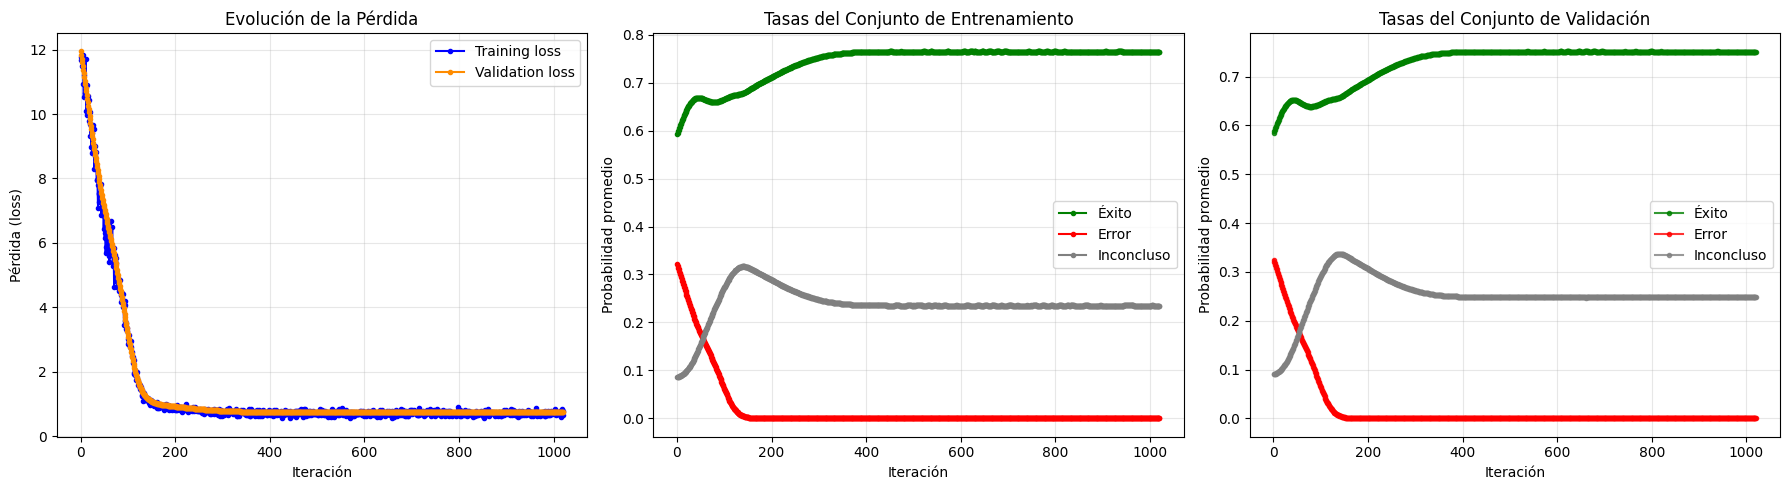

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

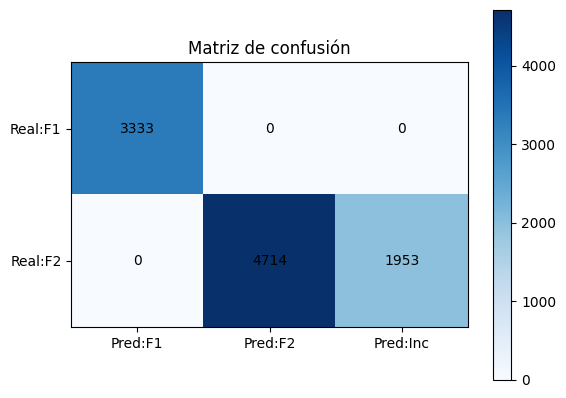

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
